In [9]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE 

from collections import Counter
from sklearn.datasets import make_classification
from interpret.blackbox import LimeTabular
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [10]:
def data_read_function( ):
    all_data = pd.read_csv(r'/Users/ihteshamshah/Desktop/Postdoc/Dataset/NKR_IKNL_breast_syntheticdata.csv')
    DataSet= all_data[['leeft' ,'gesl', 'tumsoort', 'diag_basis', 'topo', 'topo_sublok', 'later', 'morf', 'ct', 'cn', 'cm', 'cstadium', 'er_stat', 'pr_stat', 'her2_stat', 'dcis_comp', 'multifoc','chemo', 'target', 'horm', 'rt', 'meta_chir']]
    DataSet.columns = ['Age_at_incidence_date', 'Sex', 
                    'Tumor_type', 'Basis_for_diagnosis', 'Topography_excluding', 
                    'Topography_including', 'Lateralization', 'Morphology', 'cT_TNM', 'cN_TNM', 'cm_TNM',
                    'Stage_based_on_cTNM', 'Er_status', 'Pr_status', 'HER2_state', 'DCIS_component',
                      'Tumor_multifocality', 'chemo','target','hormonal','radio','surgery']
    DataSet.dropna(inplace=True)
    data = pd.get_dummies(DataSet, drop_first = False) #drop_first= ture prevents from dummy trap and it delete the first column.
    data.reset_index(drop=True, inplace=True)
    #DATA=data #for later use when dealing with imbalance dataset (weight and smote methods)
    X = data.loc[:, ~data.columns.isin(['chemo','target','hormonal','radio','surgery'])]
    Y = data[['chemo','target','hormonal','radio','surgery']]
    classes_names = {'chemo':['chemo_0','chemo_presurgical only','chemo_post-surgical only','chemo_pre and post surgical','chemo_Yes, no surgery'],
            'target':['target_0','target_presurgical only','target_post-surgical only','target_pre and post surgical','target_Yes, no surgery'],
            'hormonal':['hormonal_0','hormonal_presurgical only','hormonal_post-surgical only','hormonal_pre and post surgical','hormonal_Yes, no surgery'],
            'radio':['radio_0','radio_presurgical only','radio_post-surgical only','radio_Yes, no surgery'],
            'surgery':['No_surgery','surgery']}
    return data, X,Y,classes_names

In [11]:
def computing_j (rf, x_test, y_test):
    J=[]
    for j in range(500):
    #j=14
        data_row = x_test.iloc[[j], :] #single instance from the test dataset
        sample =data_row.values.reshape(1, -1) 
        if rf.predict(sample)[0]==1 and y_test[j]==1:
            J.append(j)
    return J
    #print(f'Actual class: {y_test[j]}')
    #print(f'Predicted class: {rf.predict(sample)[0]}')
    #print(f'Prediction for 1st sample in X_test: {rf.predict_proba(x_test.iloc[[j], :])[0]}')


def shap_explain(model, x_train, y_test, data_row,Predicted_class):
    warnings.filterwarnings('ignore')
    #Shap Explainer single instance 
    #Shap_fidelity=[]
    # Define the number of samples to summarize the background data
    K = 200  # Choose an appropriate value for K

    # Summarize the background data using shap.sample()
    background_sample = shap.sample(x_train, K)

    # Use the summarized background sample in your SHAP model
    Shap_explainer = shap.KernelExplainer(model, data=background_sample)


    shap_values= Shap_explainer.shap_values(data_row, nsamples=2000, l1_reg="num_features(46)")
    #shap_fedilty= ((rf.predict_proba(x_test[i:i+1])[0][1]) /
    # Provided SHAP values and column names
    shap_valuesss = shap_values[Predicted_class][0]
    column_namesss = x_train.columns
    # Flatten shap_values array
    #shap_values = shap_values.flatten()

    # Filter positive SHAP values
    positive_shap_indices = np.where(shap_valuesss > 0)[0]
    positive_shap_values = shap_valuesss[positive_shap_indices]
    positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

    # Combine and sort by SHAP values
    positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
    positive_shap_list.sort(key=lambda x: x[1], reverse=False)

    # Select top 20
    top_10_shap = positive_shap_list[:25]

    return top_10_shap

def lime_explain (model,x_train,y_test, sample, Predicted_class):
    warnings.filterwarnings('ignore')
    #Lime Explainer
    #Predicted_class= rf.predict(sample)[0]
    LIME_explainer = LimeTabularExplainer(x_train.values, 
                                 feature_names=x_train.columns, 
                                 class_names=classes_names[y_test.name], 
                                 discretize_continuous=True, verbose=True)

    LIME_explanation = LIME_explainer.explain_instance(sample[0], model, num_features=46, num_samples=2000, top_labels=20)
    
        ##############. Lime  #################
    lime_values_of_Prid_cls= LIME_explanation.local_exp[Predicted_class]
    column_names=x_train.columns
    positive_list = [(x, y) for x, y in lime_values_of_Prid_cls if y > 0]
    # Separate the x and y values
    x_values = [x for x, y in positive_list]
    x_names = [column_names[t] for t in x_values]
    y_values = [y for x, y in positive_list]

    # Combine x_names and y_values into a list of tuples and sort by y_values
    sorted_list = sorted(zip(x_names, y_values), key=lambda pair: pair[1], reverse=False)[:25]
    
    return sorted_list




In [12]:
# Example: Suppose medical_guidelines is a dictionary with feature importance
def Guidlines( ):
    medical_guidelines = {
        'cm_TNM': 'High',
        'cN_TNM_1': 'High',
        'cN_TNM_0': 'Low',
        'cT_TNM_1': 'High',
        'cT_TNM_1A': 'High',
         'cT_TNM_1B': 'High',
        'cT_TNM_1C': 'High',
        'cT_TNM_1M': 'High', 
        'cT_TNM_2': 'High',
           'cT_TNM_3': 'High', 'cT_TNM_4A': 'High', 'cT_TNM_4B': 'High', 'cT_TNM_4C': 'High', 'cT_TNM_4D': 'High',
           'cT_TNM_IS': 'Low', 'cN_TNM_1': 'Low', 'cN_TNM_2A': 'High', 'cN_TNM_2B': 'High', 'cN_TNM_3A': 'High',
        'cT_TNM_2': 'High',
        'Er_status':'High',
        'Pr_status':'High',
        'Stage_based_on_cTNM_3A': 'High', 'Stage_based_on_cTNM_3B': 'High','Stage_based_on_cTNM_3C': 'High', 'Stage_based_on_cTNM_4': 'High',
        'Morphology':'High',
        'DCIS_component':'Low',


    }
    return medical_guidelines


def map_importance(feature, importance_list):
    for item in importance_list:
        if item[0] == feature:
            return item[1]
    return 0

def compare_with_guidelines(important_features, guidelines):
    comparison = []
    for feature in guidelines:
        importance = map_importance(feature, important_features)
        comparison.append((feature, importance, guidelines[feature]))
    return comparison

def calculate_concordance(comparison):
        concordant_pairs = 0
        for feature, model_importance, guideline_importance in comparison:
            if (model_importance > 0 and guideline_importance == 'High') or (model_importance == 0 and guideline_importance == 'Low'):
                concordant_pairs += 1
        return concordant_pairs / len(comparison)


In [13]:
def Plot_the_data(Plot_Data, Colors):
    # Data
    data = Plot_Data
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(16, 8))

    # Labels and positions
    labels = list(data.keys())
    positions = np.array(range(len(labels))) * 2.0

    # Colors for SHAP and LIME
    colors = Colors

    # Plot each boxplot
    for i, (label, values) in enumerate(data.items()):
        bp_shap = ax.boxplot(values[0], positions=[positions[i] - 0.2], widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[0]))
        bp_lime = ax.boxplot(values[1], positions=[positions[i] + 0.25], widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[1]))

    # Adding legend
    ax.legend([bp_shap["boxes"][0], bp_lime["boxes"][0]], ['SHAP', 'LIME'], loc='upper right')

    # Set the axes ticks and labels
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)

    # Adding grid
    ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
    ax.set_axisbelow(True)

    # Adding X and Y axis labels
    ax.set_xlabel(' ')
    ax.set_ylabel('Values')

    plt.show()

In [14]:
def main_function_guidlineComparison (data, X, Y, classes_names, Plot_Data, treatment_name): 
    warnings.filterwarnings('ignore')
    Lime_Concordance=[]
    SHAP_Concordance=[]

    #for _ in range(5):

    y=Y[treatment_name]

    smote = SMOTE(random_state=42)

    X_class_resampled, y_class_resampled = smote.fit_resample(X , y)

    X_class_resampled.replace({False: 0, True: 1}, inplace=True)
    y_class_resampled.replace({False:0, True:1}, inplace= True)

    x_train,x_test,y_train,y_test=train_test_split(X_class_resampled,y_class_resampled,test_size=0.2)

    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    #X_res, y_res = sm.fit_resample(x_train, y_train)

    #Randomforest Classifier
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    medical_guidelines= Guidlines( ) #function for medical guidlines
    j_list= computing_j (rf, x_test, y_test)[:10]
    #print('j_list', j_list)
    for j in j_list:
        data_row = X.iloc[[j], :] #single instance from the test dataset
        sample =data_row.values.reshape(1, -1) 
        Predicted_class= rf.predict(sample)[0]
        shap_important_features= shap_explain(rf.predict_proba, x_train, y_test, data_row,Predicted_class)
        lime_features = lime_explain (rf.predict_proba, x_train, y_test, sample,Predicted_class)

        # Compare LIME
        lime_comparison = compare_with_guidelines(lime_features, medical_guidelines)

        # Compare SHAP
        shap_comparison = compare_with_guidelines(shap_important_features, medical_guidelines)

        #print("LIME Comparison with Guidelines:", lime_comparison)
        #print("SHAP Comparison with Guidelines:", shap_comparison)

        lime_concordance = calculate_concordance(lime_comparison)
        shap_concordance = calculate_concordance(shap_comparison)

        #print("LIME Concordance with Guidelines:", lime_concordance)
        #print("SHAP Concordance with Guidelines:", shap_concordance)

        Lime_Concordance.append(lime_concordance)
        SHAP_Concordance.append(shap_concordance)
    
    Plot_Data[y_test.name]=[Lime_Concordance, SHAP_Concordance]
    
    return Plot_Data
    

    
    


# Comparison explaination with medical guidlines

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.06516317375963754
Prediction_local [0.22705526]
Right: 0.01
Intercept 0.6962267153470845
Prediction_local [0.1197066]
Right: 0.02
Intercept 0.39962876768948613
Prediction_local [0.32913663]
Right: 0.05
Intercept -0.12464035591420297
Prediction_local [0.30379114]
Right: 0.33116666666666666
Intercept 0.09602991927700684
Prediction_local [0.02028628]
Right: 0.5888333333333333


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.04213707141119233
Prediction_local [0.16266227]
Right: 0.0
Intercept 0.7349840463584841
Prediction_local [0.11143466]
Right: 0.0
Intercept 0.0653888288393388
Prediction_local [0.02324522]
Right: 0.07
Intercept -0.1134614225866507
Prediction_local [0.37419166]
Right: 0.23
Intercept 0.3582440518683665
Prediction_local [0.32729388]
Right: 0.7


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11357710012263307
Prediction_local [0.0401485]
Right: 0.0
Intercept -0.015352760882867189
Prediction_local [0.30548225]
Right: 0.01
Intercept 0.7138236529748133
Prediction_local [0.12457867]
Right: 0.01
Intercept 0.04820480624018193
Prediction_local [0.08918872]
Right: 0.29
Intercept 0.14013061689128722
Prediction_local [0.44069236]
Right: 0.69


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.025444002609390948
Prediction_local [0.18545646]
Right: 0.0
Intercept 0.7628764457112857
Prediction_local [0.1080628]
Right: 0.0
Intercept 0.33351799635909735
Prediction_local [0.33820457]
Right: 0.07
Intercept -0.18232716636369745
Prediction_local [0.34791158]
Right: 0.23399999999999999
Intercept 0.11066909100081754
Prediction_local [0.02052341]
Right: 0.696


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.03979824231291365
Prediction_local [0.18055711]
Right: 0.0
Intercept 0.8225930805140788
Prediction_local [0.05876293]
Right: 0.0
Intercept 0.32273181877805446
Prediction_local [0.38052719]
Right: 0.03
Intercept -0.225019205739306
Prediction_local [0.33419885]
Right: 0.08
Intercept 0.04062572797556669
Prediction_local [0.04575572]
Right: 0.89


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.6730304924738975
Prediction_local [0.10827371]
Right: 0.0
Intercept 0.33930266562774586
Prediction_local [0.33218125]
Right: 0.02
Intercept 0.0026378640424243593
Prediction_local [0.18761273]
Right: 0.02
Intercept 0.05203519352517903
Prediction_local [0.02739167]
Right: 0.22
Intercept -0.0673503421716079
Prediction_local [0.34460347]
Right: 0.74


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7141158395849606
Prediction_local [0.07571352]
Right: 0.0
Intercept -0.21116990343592767
Prediction_local [0.3726878]
Right: 0.04
Intercept 0.3040100964708045
Prediction_local [0.31933452]
Right: 0.06
Intercept 0.13931603687480137
Prediction_local [0.18012451]
Right: 0.16
Intercept 0.051254511833114996
Prediction_local [0.05217655]
Right: 0.74


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16208728135163594
Prediction_local [0.10571205]
Right: 0.0
Intercept 0.7185958145175344
Prediction_local [0.10697668]
Right: 0.0
Intercept -0.1517397954980224
Prediction_local [0.3157795]
Right: 0.04
Intercept 0.028166785952254948
Prediction_local [0.07783229]
Right: 0.25
Intercept 0.24308755339828653
Prediction_local [0.39365348]
Right: 0.71


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.17448612418770598
Prediction_local [0.35701219]
Right: 0.0
Intercept 0.0616264264142556
Prediction_local [0.18000506]
Right: 0.0
Intercept 0.7495414267591218
Prediction_local [0.09560588]
Right: 0.0
Intercept 0.3067745307250401
Prediction_local [0.33761924]
Right: 0.008
Intercept 0.05677782633799604
Prediction_local [0.02979077]
Right: 0.992


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.06953732754403522
Prediction_local [0.04978535]
Right: 0.0
Intercept 0.7258808289443961
Prediction_local [0.08726634]
Right: 0.04
Intercept 0.31559707294290346
Prediction_local [0.45368648]
Right: 0.07
Intercept 0.040914213250892534
Prediction_local [0.07300428]
Right: 0.1
Intercept -0.15244017851655128
Prediction_local [0.33556795]
Right: 0.79


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.45220695916211207
Prediction_local [0.14090083]
Right: 0.0
Intercept 0.11358778880559425
Prediction_local [0.2810763]
Right: 0.0
Intercept 0.11544278223670312
Prediction_local [0.1931933]
Right: 0.02
Intercept 0.3085015655233297
Prediction_local [0.29594454]
Right: 0.03
Intercept 0.01006564180057154
Prediction_local [0.08912257]
Right: 0.95


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.5174663544336349
Prediction_local [0.10466473]
Right: 0.0
Intercept -0.007719632808147026
Prediction_local [0.3383541]
Right: 0.0
Intercept 0.35672530034259353
Prediction_local [0.27417372]
Right: 0.02
Intercept 0.10003149839173742
Prediction_local [0.14864162]
Right: 0.04
Intercept 0.03357652983004728
Prediction_local [0.1341511]
Right: 0.94


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.19731132895776404
Prediction_local [0.0269001]
Right: 0.01
Intercept 0.3022694896230569
Prediction_local [0.2979952]
Right: 0.02
Intercept 0.27642458090190625
Prediction_local [0.29669266]
Right: 0.05
Intercept 0.22195821447217956
Prediction_local [0.24823306]
Right: 0.22
Intercept 6.87406609455321e-05
Prediction_local [0.13045292]
Right: 0.7


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.38733344465813
Prediction_local [0.16227247]
Right: 0.0
Intercept 0.12444807668751981
Prediction_local [0.30781639]
Right: 0.0
Intercept 0.0886927374437484
Prediction_local [0.13854185]
Right: 0.0
Intercept 0.39105682141372655
Prediction_local [0.30228741]
Right: 0.09
Intercept 0.008773915600007058
Prediction_local [0.08899537]
Right: 0.91


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.30995796793485947
Prediction_local [0.28759071]
Right: 0.0
Intercept 0.26676175249293305
Prediction_local [0.06000749]
Right: 0.0
Intercept 0.1424354373331464
Prediction_local [0.25485437]
Right: 0.01
Intercept -0.0009768518694245054
Prediction_local [0.08382648]
Right: 0.04
Intercept 0.28235356895969393
Prediction_local [0.31393481]
Right: 0.95


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.37997995926652295
Prediction_local [0.16492092]
Right: 0.0
Intercept 0.366365623497937
Prediction_local [0.2659779]
Right: 0.0
Intercept 0.029560269676061623
Prediction_local [0.18166057]
Right: 0.0
Intercept 0.10313842942781921
Prediction_local [0.09406085]
Right: 0.25
Intercept 0.12181501087223673
Prediction_local [0.29338395]
Right: 0.75


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.17166875193235825
Prediction_local [0.30537707]
Right: 0.0
Intercept 0.007008521946447244
Prediction_local [0.17154325]
Right: 0.0
Intercept 0.4885067945842488
Prediction_local [0.12368495]
Right: 0.03
Intercept 0.30670232826096105
Prediction_local [0.29268367]
Right: 0.05
Intercept 0.02558981863085029
Prediction_local [0.10675953]
Right: 0.92


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.451776532170308
Prediction_local [0.11802724]
Right: 0.0
Intercept 0.14315167937133708
Prediction_local [0.25077961]
Right: 0.0
Intercept 0.043064766240939134
Prediction_local [0.12588786]
Right: 0.01
Intercept 0.40113726905608427
Prediction_local [0.29879671]
Right: 0.015
Intercept -0.039606164383713824
Prediction_local [0.20694809]
Right: 0.975


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.4681987270711959
Prediction_local [0.18471483]
Right: 0.0
Intercept 0.40033157755931115
Prediction_local [0.24687977]
Right: 0.0
Intercept 0.1673773223563425
Prediction_local [0.15598811]
Right: 0.02
Intercept 0.040784185549103125
Prediction_local [0.28394961]
Right: 0.04
Intercept -0.0780276321231104
Prediction_local [0.12878037]
Right: 0.94


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.2900162951527536
Prediction_local [0.2770534]
Right: 0.0
Intercept 0.27237574918669955
Prediction_local [0.05200556]
Right: 0.01
Intercept 0.32234492905831424
Prediction_local [0.20813414]
Right: 0.02
Intercept 0.19065292079920748
Prediction_local [0.29029031]
Right: 0.06
Intercept -0.07489370341730567
Prediction_local [0.17237711]
Right: 0.91


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.058017101802752255
Prediction_local [0.19943709]
Right: 0.0
Intercept 0.7952754245168958
Prediction_local [0.37714486]
Right: 0.0
Intercept 0.12585862917713786
Prediction_local [0.29310194]
Right: 0.01
Intercept -0.06981123396917839
Prediction_local [0.12661712]
Right: 0.095
Intercept 0.09120477986295072
Prediction_local [0.00323656]
Right: 0.895


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14541377034605815
Prediction_local [0.13127436]
Right: 0.0
Intercept 0.07572711393772477
Prediction_local [0.259154]
Right: 0.0
Intercept 0.9127518952440183
Prediction_local [0.39581596]
Right: 0.0
Intercept -0.10781807428686294
Prediction_local [0.1527914]
Right: 0.023333333333333334
Intercept -0.024249563896645218
Prediction_local [0.06037581]
Right: 0.9766666666666666


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.3360079945194647
Prediction_local [0.0229143]
Right: 0.01
Intercept 0.6687549557843686
Prediction_local [0.37361585]
Right: 0.01
Intercept 0.27789262613195853
Prediction_local [0.10325529]
Right: 0.03
Intercept -0.13451702635941287
Prediction_local [0.17277874]
Right: 0.12
Intercept -0.1471578242672617
Prediction_local [0.32765145]
Right: 0.83


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.3484587758080977
Prediction_local [-0.00920134]
Right: 0.0
Intercept 0.13278404315249218
Prediction_local [0.32552966]
Right: 0.01
Intercept 0.6151135143589385
Prediction_local [0.49477691]
Right: 0.02
Intercept -0.002729240986782372
Prediction_local [0.09471009]
Right: 0.2
Intercept -0.09272279259252242
Prediction_local [0.0941263]
Right: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.17497106148857294
Prediction_local [0.12932609]
Right: 0.0
Intercept 0.7883355530438825
Prediction_local [0.38273421]
Right: 0.01
Intercept 0.055631578273540594
Prediction_local [0.29442089]
Right: 0.02
Intercept 0.07694251152396672
Prediction_local [0.02828475]
Right: 0.08
Intercept -0.09586738334780456
Prediction_local [0.16438303]
Right: 0.89


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.33058549700153084
Prediction_local [0.00830241]
Right: 0.0
Intercept 0.20017222938181917
Prediction_local [0.2065597]
Right: 0.0
Intercept -0.048009373729885854
Prediction_local [0.13996951]
Right: 0.04
Intercept -0.08608510834922296
Prediction_local [0.19132896]
Right: 0.28
Intercept 0.6019292821449269
Prediction_local [0.45389463]
Right: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.2722763777962231
Prediction_local [0.06758763]
Right: 0.0
Intercept 0.18688134479125898
Prediction_local [0.26346106]
Right: 0.01
Intercept 0.6981244568958688
Prediction_local [0.39242674]
Right: 0.02
Intercept -0.08285470003676194
Prediction_local [0.16732915]
Right: 0.17
Intercept -0.07447016748534341
Prediction_local [0.10956075]
Right: 0.8


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.18490187221345084
Prediction_local [0.16399541]
Right: 0.0
Intercept -0.03359034749913512
Prediction_local [0.04172382]
Right: 0.0
Intercept 0.2931968608264217
Prediction_local [0.24647218]
Right: 0.0
Intercept 0.6246571403791432
Prediction_local [0.39996072]
Right: 0.0
Intercept -0.07111971415449035
Prediction_local [0.14779369]
Right: 1.0


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.42916667727941005
Prediction_local [-0.0236497]
Right: 0.0
Intercept 0.07420127971543711
Prediction_local [0.29672543]
Right: 0.0
Intercept 0.5190914784864491
Prediction_local [0.45058156]
Right: 0.0
Intercept 0.013263353792223806
Prediction_local [0.13679766]
Right: 0.1425714285714286
Intercept -0.035240734382396055
Prediction_local [0.13938681]
Right: 0.8574285714285717


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.24129704435534893
Prediction_local [0.00034232]
Right: 0.0
Intercept 0.15277958110607975
Prediction_local [0.31625076]
Right: 0.0
Intercept 0.724624273911723
Prediction_local [0.47852516]
Right: 0.01
Intercept -0.04634304018856218
Prediction_local [0.09411633]
Right: 0.2058333333333333
Intercept -0.07172371557015568
Prediction_local [0.11074235]
Right: 0.7841666666666667


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept -0.04744610758734957
Prediction_local [0.25141357]
Right: 0.0
Intercept 0.775905706761679
Prediction_local [0.22789347]
Right: 0.01
Intercept 0.0878615151617296
Prediction_local [0.07568676]
Right: 0.35
Intercept 0.18363817629635354
Prediction_local [0.44493304]
Right: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept -0.08159315894419661
Prediction_local [0.28407345]
Right: 0.02
Intercept 0.8280918985182186
Prediction_local [0.17911883]
Right: 0.07
Intercept 0.18416452558706106
Prediction_local [0.43263809]
Right: 0.33
Intercept 0.07113370119927498
Prediction_local [0.10377492]
Right: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7051519194081244
Prediction_local [0.29012551]
Right: 0.02
Intercept 0.11679583956672773
Prediction_local [0.26020829]
Right: 0.12
Intercept 0.14415112133180358
Prediction_local [0.0453688]
Right: 0.16
Intercept 0.034310357953500514
Prediction_local [0.40428469]
Right: 0.7


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.08635450098259256
Prediction_local [0.33249097]
Right: 0.0
Intercept 0.6645569229948607
Prediction_local [0.26027857]
Right: 0.0
Intercept 0.2049866452486346
Prediction_local [0.36486063]
Right: 0.27988275613275604
Intercept 0.045428495847936325
Prediction_local [0.04223166]
Right: 0.7201172438672436


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.648607788946907
Prediction_local [0.27087595]
Right: 0.0
Intercept 0.21572818767039328
Prediction_local [0.14949255]
Right: 0.02
Intercept 0.1266509182114104
Prediction_local [0.45952344]
Right: 0.06
Intercept 0.009375561928414239
Prediction_local [0.12067527]
Right: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.14906661825179932
Prediction_local [0.17583914]
Right: 0.0
Intercept 0.6478284081440101
Prediction_local [0.30873724]
Right: 0.0
Intercept 0.1694361692579685
Prediction_local [0.41204671]
Right: 0.26
Intercept 0.03516986551600914
Prediction_local [0.10334811]
Right: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08580745496810185
Prediction_local [0.23516161]
Right: 0.0
Intercept 0.7392075536674529
Prediction_local [0.24844673]
Right: 0.0
Intercept 0.09684447844363236
Prediction_local [0.44497966]
Right: 0.2
Intercept 0.07901359979181205
Prediction_local [0.07140245]
Right: 0.8


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.02654756885896159
Prediction_local [0.28331735]
Right: 0.0
Intercept 0.7762127843318772
Prediction_local [0.2355191]
Right: 0.0
Intercept 0.1780527499809284
Prediction_local [0.40243235]
Right: 0.08
Intercept 0.018735903889518374
Prediction_local [0.07862426]
Right: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.516327758301025
Prediction_local [0.2547504]
Right: 0.0
Intercept 0.19525030970079232
Prediction_local [0.23971782]
Right: 0.02
Intercept 0.3119685827645817
Prediction_local [0.41000841]
Right: 0.32
Intercept -0.024403621860523687
Prediction_local [0.09575071]
Right: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10091475267562608
Prediction_local [0.2221256]
Right: 0.0
Intercept 0.6783268179082556
Prediction_local [0.2657381]
Right: 0.0
Intercept 0.19029141523528217
Prediction_local [0.43153532]
Right: 0.175
Intercept 0.03027056020307939
Prediction_local [0.08059376]
Right: 0.825


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.9289792508014791
Prediction_local [0.91147525]
Right: 0.04
Intercept 0.07102074919852083
Prediction_local [0.08852475]
Right: 0.96


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.9423635479145536
Prediction_local [0.93481054]
Right: 0.02
Intercept 0.05763645208544628
Prediction_local [0.06518946]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.8579369158458803
Prediction_local [0.89387437]
Right: 0.01
Intercept 0.1420630841541196
Prediction_local [0.10612563]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 1.0068129070525593
Prediction_local [0.74110817]
Right: 0.0
Intercept -0.006812907052559297
Prediction_local [0.25889183]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.93943404054532
Prediction_local [0.90501206]
Right: 0.02
Intercept 0.06056595945468
Prediction_local [0.09498794]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.9325117483733429
Prediction_local [0.85994405]
Right: 0.0
Intercept 0.06748825162665689
Prediction_local [0.14005595]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 1.099723638990463
Prediction_local [0.80053216]
Right: 0.06
Intercept -0.09972363899046313
Prediction_local [0.19946784]
Right: 0.94


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.9763054216234079
Prediction_local [0.76369242]
Right: 0.02
Intercept 0.02369457837659185
Prediction_local [0.23630758]
Right: 0.98


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Intercept 0.9417374663246243
Prediction_local [0.875841]
Right: 0.0
Intercept 0.058262533675375594
Prediction_local [0.124159]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7416241337085745
Prediction_local [0.95540982]
Right: 0.02
Intercept 0.2583758662914254
Prediction_local [0.04459018]
Right: 0.98


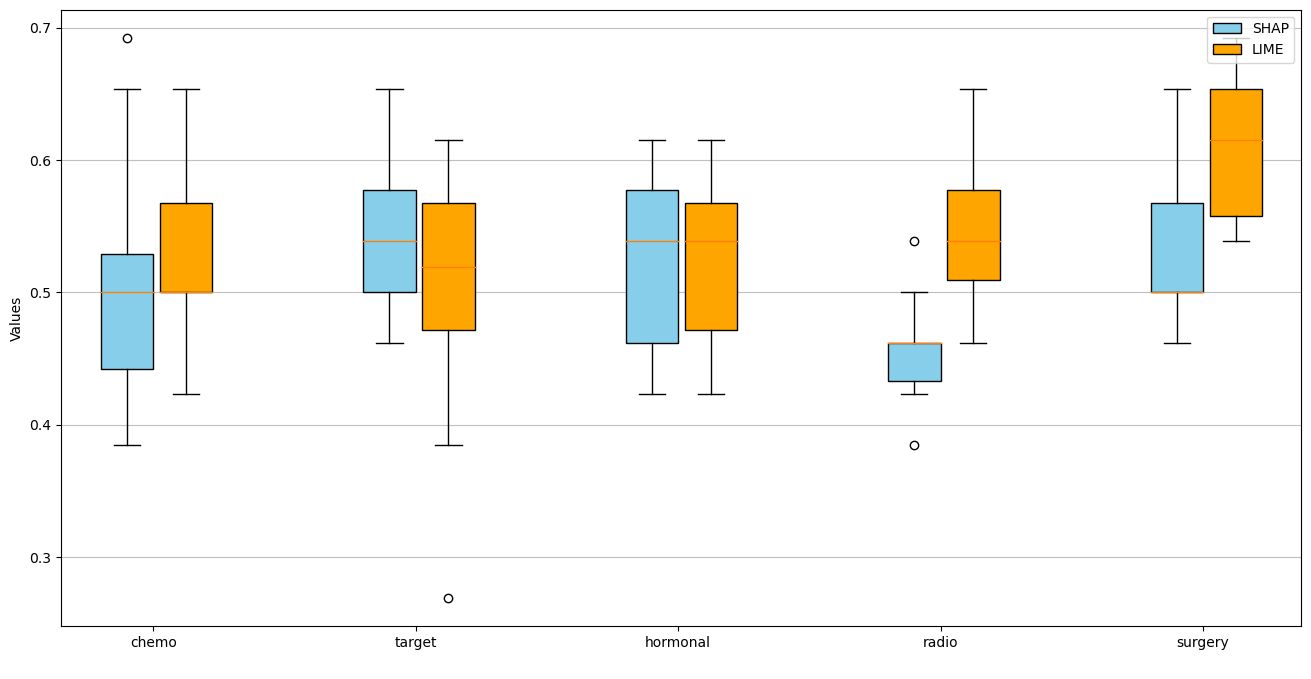

In [15]:
warnings.filterwarnings('ignore')
data, X, Y, classes_names = data_read_function( )
Plot_Data={}
Treatments=['chemo','target','hormonal','radio','surgery']
for treatment_name in Treatments :
    Plot_Data= main_function_guidlineComparison(data, X, Y, classes_names, Plot_Data, treatment_name)

colors = ['skyblue', 'orange'] #plot colors
Plot_the_data(Plot_Data, colors)

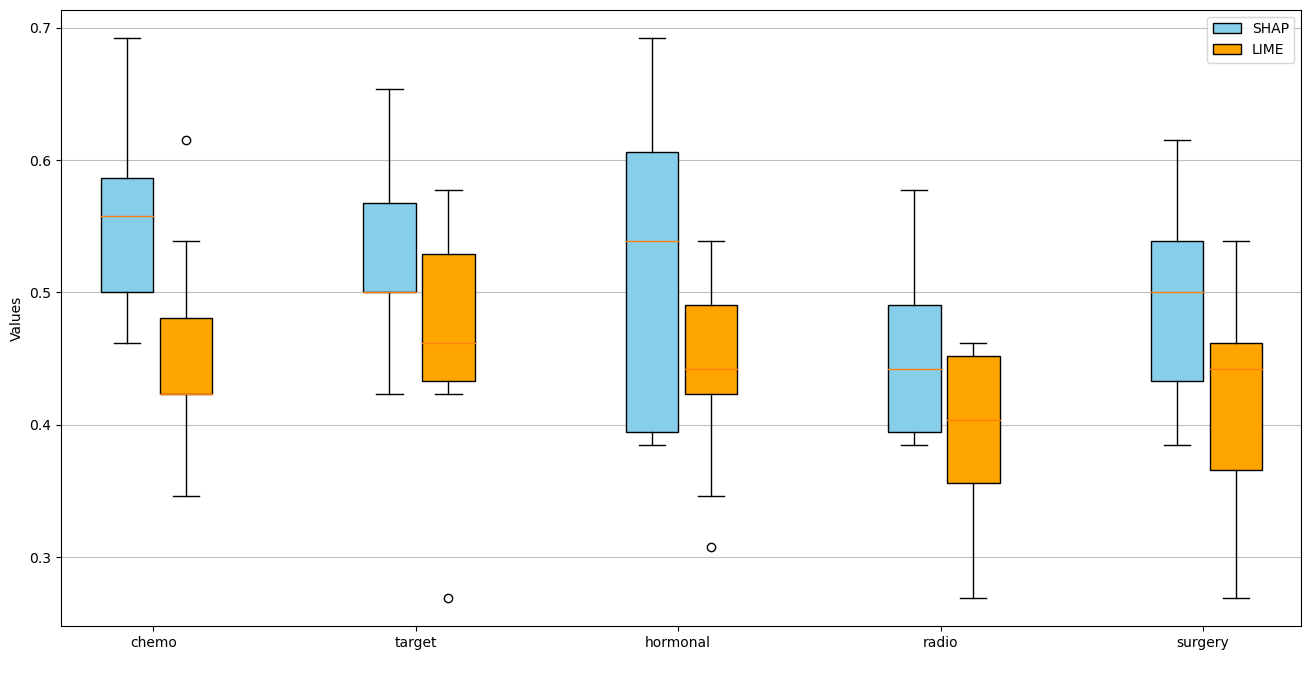

In [955]:
Plot_the_data(Plot_Data)

# LIME and SHAP fidelity

In [16]:
#LIME explainer single instance for same sample used for shap
# Choose a sample to explain
#discretize_continuous=True, verbose=True show the following outcomes.
#intercept , Prediction_local= Lime prediction, Right= Actual model's prediction.
def Lime_Shap_fidelity(data, X, Y, classes_names, fidelity_Plot_Data, treatment_name): 
    warnings.filterwarnings('ignore')


    #for _ in range(5):

    y=Y[treatment_name]

    smote = SMOTE(random_state=42)

    X_class_resampled, y_class_resampled = smote.fit_resample(X , y)

    X_class_resampled.replace({False: 0, True: 1}, inplace=True)
    y_class_resampled.replace({False:0, True:1}, inplace= True)

    x_train,x_test,y_train,y_test=train_test_split(X_class_resampled,y_class_resampled,test_size=0.2)

    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    #X_res, y_res = sm.fit_resample(x_train, y_train)

    #Randomforest Classifier
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    
    



    Lime_fidelity=[]
    Shap_fidelity=[]

    #Lime Explainer
    LIME_explainer = LimeTabularExplainer(x_train.values, 
                                 feature_names=x_train.columns, 
                                 class_names=classes_names[y_test.name], 
                                 discretize_continuous=True, verbose=True)
    #Shap Explainer 

    # Define the number of samples to summarize the background data
    K = 100  # Choose an appropriate value for K

    # Summarize the background data using shap.sample()
    background_sample = shap.sample(x_train, K)

    # Use the summarized background sample in your SHAP model
    #Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample, link = 'logit')
    Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample)

    # Explanation over 20 single points 

    #j=np.random.randint(1000, size=(20)) #randomly pick 20 instances from data (in the range of 1000 intances)

    j_list= computing_j (rf, x_test, y_test)[:15]
    
    for j in j_list:
        data_row = x_test.iloc[[j], :] #single instance from the test dataset
        sample =data_row.values.reshape(1, -1) #reshape the sample and pickup the value only (making it suitble for lime function)
        #print(f'Actual class: {y_test[j]}')
        #print(f'Predicted class: {rf.predict(sample)[0]}')

        # Explain the prediction for the chosen sample
        LIME_explanation = LIME_explainer.explain_instance(sample[0], rf.predict_proba, num_features=46, num_samples=2000, top_labels=20)
        #AA= np.array(exp.local_pred, dtype==int)
        Lime_fidelity.append(LIME_explanation.score)


        #Data_row = x_test.iloc[[3], :]
        Predicted_class= rf.predict(data_row)[0]


        shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=2000, l1_reg="num_features(28)")
        shap_fedilty= ((rf.predict_proba(data_row)[0][Predicted_class]) /
                    (Shap_explainer.fnull[Predicted_class] + np.sum(np.abs(shap_values_single_instance[Predicted_class]))))
        Shap_fidelity.append(shap_fedilty)


    fidelity_Plot_Data[y_test.name]=[Shap_fidelity, Lime_fidelity]
    
    return fidelity_Plot_Data


Intercept 0.18323335798327903
Prediction_local [-0.01131777]
Right: 0.0
Intercept 0.05046251879484143
Prediction_local [0.22293556]
Right: 0.05
Intercept 0.7113685916881789
Prediction_local [0.14357171]
Right: 0.07
Intercept -0.16576704847336288
Prediction_local [0.27694297]
Right: 0.22
Intercept 0.22169543700187172
Prediction_local [0.36778212]
Right: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16408434803884686
Prediction_local [0.02183111]
Right: 0.0
Intercept 0.723323233147888
Prediction_local [0.08331935]
Right: 0.01
Intercept -0.11073512184256643
Prediction_local [0.20988586]
Right: 0.14
Intercept -0.07500616659129472
Prediction_local [0.32894555]
Right: 0.24
Intercept 0.29784956507921073
Prediction_local [0.35599572]
Right: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1433331518144791
Prediction_local [0.01544787]
Right: 0.0
Intercept 0.6341510301920598
Prediction_local [0.09804852]
Right: 0.0
Intercept -0.09381566589906579
Prediction_local [0.20882489]
Right: 0.01
Intercept -0.0634087800192284
Prediction_local [0.29212937]
Right: 0.04
Intercept 0.37841739561848314
Prediction_local [0.38604929]
Right: 0.95


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.0010237547249064283
Prediction_local [0.1205347]
Right: 0.0
Intercept 0.6919609743570643
Prediction_local [0.11135493]
Right: 0.0
Intercept 0.08452943378041987
Prediction_local [0.06350307]
Right: 0.2843333333333334
Intercept 0.003091790020092966
Prediction_local [0.30148945]
Right: 0.30999999999999994
Intercept 0.21963693066903345
Prediction_local [0.40190246]
Right: 0.4056666666666667


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7130209776524692
Prediction_local [0.09555431]
Right: 0.01
Intercept -0.03098024410949371
Prediction_local [0.19578809]
Right: 0.03
Intercept 0.11837658080607896
Prediction_local [0.02320178]
Right: 0.04
Intercept -0.15417493132516014
Prediction_local [0.34434446]
Right: 0.16
Intercept 0.35568684061138406
Prediction_local [0.34103116]
Right: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.01537911493792346
Prediction_local [0.13001861]
Right: 0.03
Intercept 0.7259508819030627
Prediction_local [0.12053808]
Right: 0.03
Intercept 0.12014763361992394
Prediction_local [0.04001551]
Right: 0.11
Intercept -0.17347285708433452
Prediction_local [0.30318339]
Right: 0.17
Intercept 0.31255444047118147
Prediction_local [0.40569101]
Right: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.595916964408606
Prediction_local [0.06277658]
Right: 0.0
Intercept -0.09086646986514421
Prediction_local [0.16813645]
Right: 0.11
Intercept 0.1396467048103223
Prediction_local [0.05724147]
Right: 0.17
Intercept -0.027690503522753374
Prediction_local [0.32905188]
Right: 0.35
Intercept 0.38306072720770135
Prediction_local [0.3825895]
Right: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.02193431772607507
Prediction_local [0.21177141]
Right: 0.0
Intercept 0.6868576509977724
Prediction_local [0.11555575]
Right: 0.0
Intercept -0.1412157162665315
Prediction_local [0.30307833]
Right: 0.03935795542634569
Intercept 0.16630581843900466
Prediction_local [0.01652804]
Right: 0.09118161610961169
Intercept 0.3108339119408169
Prediction_local [0.35310088]
Right: 0.8694604284640424


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.020770206531218027
Prediction_local [0.21194276]
Right: 0.0
Intercept 0.6546903597807121
Prediction_local [0.12877615]
Right: 0.03
Intercept 0.16244197366878144
Prediction_local [-0.00103721]
Right: 0.1
Intercept -0.11707652924278805
Prediction_local [0.30149199]
Right: 0.2
Intercept 0.32264694878066674
Prediction_local [0.35841437]
Right: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.6634447658769744
Prediction_local [0.12029411]
Right: 0.0
Intercept 0.12657193297244007
Prediction_local [0.02562526]
Right: 0.01
Intercept 0.05265043882311356
Prediction_local [0.18521566]
Right: 0.01
Intercept -0.20620850780519612
Prediction_local [0.29750085]
Right: 0.1
Intercept 0.36407043585233406
Prediction_local [0.37137067]
Right: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.7311494174559269
Prediction_local [0.08351338]
Right: 0.01
Intercept 0.1265585806856774
Prediction_local [0.01242729]
Right: 0.02
Intercept 0.026487775698666283
Prediction_local [0.23859594]
Right: 0.1925
Intercept -0.12998778637258301
Prediction_local [0.30936076]
Right: 0.30625
Intercept 0.24579425102444868
Prediction_local [0.35610683]
Right: 0.47125


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.0830519167508542
Prediction_local [0.02794984]
Right: 0.0
Intercept 0.03294888460047515
Prediction_local [0.16973998]
Right: 0.04
Intercept 0.6735398446553669
Prediction_local [0.1267945]
Right: 0.11
Intercept -0.21854483034645322
Prediction_local [0.35088638]
Right: 0.29
Intercept 0.42973479716585705
Prediction_local [0.32447995]
Right: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.13389969964491835
Prediction_local [0.17258451]
Right: 0.0
Intercept 0.12356847913667862
Prediction_local [0.05054091]
Right: 0.02
Intercept 0.6428108545291249
Prediction_local [0.10397491]
Right: 0.07
Intercept -0.1258754534959619
Prediction_local [0.31379889]
Right: 0.32935714285714285
Intercept 0.4930524962954676
Prediction_local [0.35902352]
Right: 0.580642857142857


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14480462115973367
Prediction_local [-0.00065415]
Right: 0.0
Intercept -0.024461289077650522
Prediction_local [0.21322112]
Right: 0.02
Intercept 0.6090497060936156
Prediction_local [0.12826975]
Right: 0.03
Intercept -0.00307681147816824
Prediction_local [0.27750834]
Right: 0.25
Intercept 0.2734226675810082
Prediction_local [0.38205924]
Right: 0.7


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.6231427688095188
Prediction_local [0.0946228]
Right: 0.0
Intercept 0.02702050375629722
Prediction_local [0.1510252]
Right: 0.01
Intercept 0.10958467671146123
Prediction_local [0.03682437]
Right: 0.02
Intercept -0.0890720464338417
Prediction_local [0.32188901]
Right: 0.04
Intercept 0.33087867115999275
Prediction_local [0.39533873]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11970116420313498
Prediction_local [0.07932559]
Right: 0.0
Intercept 0.12072913057393767
Prediction_local [0.06766715]
Right: 0.01
Intercept 0.2331405061898767
Prediction_local [0.31266999]
Right: 0.01
Intercept 0.19592068238069588
Prediction_local [0.23171374]
Right: 0.02
Intercept 0.3301864291937345
Prediction_local [0.30858982]
Right: 0.96


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.026481666559858744
Prediction_local [0.0509862]
Right: 0.0
Intercept 0.021242933214200066
Prediction_local [0.33692693]
Right: 0.0
Intercept 0.458158405026168
Prediction_local [0.25746994]
Right: 0.0
Intercept 0.08824717028941101
Prediction_local [0.20468606]
Right: 0.0
Intercept 0.4078571360460062
Prediction_local [0.14962598]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12814751102134517
Prediction_local [0.04211853]
Right: 0.0
Intercept 0.3460803000428001
Prediction_local [0.2187772]
Right: 0.01
Intercept -0.10634123782358179
Prediction_local [0.23846514]
Right: 0.01
Intercept 0.20340648609058665
Prediction_local [0.30175464]
Right: 0.04
Intercept 0.4287516516894623
Prediction_local [0.19882426]
Right: 0.94


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10573575259193668
Prediction_local [0.06801097]
Right: 0.0
Intercept 0.21653231187463842
Prediction_local [0.30299162]
Right: 0.0
Intercept 0.17865556118222975
Prediction_local [-0.00241033]
Right: 0.0
Intercept 0.05542909562614712
Prediction_local [0.31551986]
Right: 0.02
Intercept 0.4441252881259659
Prediction_local [0.31482328]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.02895148329116728
Prediction_local [0.08281179]
Right: 0.0
Intercept 0.02201683514667374
Prediction_local [0.13566125]
Right: 0.0
Intercept 0.06307425115441001
Prediction_local [0.26996645]
Right: 0.02
Intercept 0.40813744516625744
Prediction_local [0.26438363]
Right: 0.05
Intercept 0.4767339127478591
Prediction_local [0.24869091]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12788604104144075
Prediction_local [0.06140587]
Right: 0.0
Intercept 0.2521377732180234
Prediction_local [0.27203759]
Right: 0.0
Intercept 0.1652568945722016
Prediction_local [0.17682708]
Right: 0.01
Intercept 0.04894354827982633
Prediction_local [0.3250386]
Right: 0.02
Intercept 0.4050029807541348
Prediction_local [0.16410272]
Right: 0.97


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.050220976435686134
Prediction_local [0.06740919]
Right: 0.0
Intercept 0.051518034284691844
Prediction_local [0.16145931]
Right: 0.01
Intercept 0.3096342629294659
Prediction_local [0.2613782]
Right: 0.04
Intercept 0.04960780926994318
Prediction_local [0.30922534]
Right: 0.05
Intercept 0.539478745192023
Prediction_local [0.20054253]
Right: 0.9


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07635737482857542
Prediction_local [0.02512296]
Right: 0.0
Intercept 0.16168402444187818
Prediction_local [0.09420893]
Right: 0.0
Intercept 0.3663718057333872
Prediction_local [0.29505047]
Right: 0.01
Intercept 0.20270087413670962
Prediction_local [0.23958615]
Right: 0.03
Intercept 0.1916023936365664
Prediction_local [0.34579552]
Right: 0.96


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11247436861667925
Prediction_local [0.03128296]
Right: 0.0
Intercept 0.1812567942156217
Prediction_local [0.05760374]
Right: 0.07
Intercept 0.1868827570193597
Prediction_local [0.34895805]
Right: 0.09
Intercept 0.15698414061962543
Prediction_local [0.26657768]
Right: 0.16
Intercept 0.3629731004833904
Prediction_local [0.29560456]
Right: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10005060131378227
Prediction_local [0.03297396]
Right: 0.0
Intercept 0.3770419762509348
Prediction_local [0.24707453]
Right: 0.01
Intercept -0.09717150418357381
Prediction_local [0.21966374]
Right: 0.01
Intercept 0.2104365268782979
Prediction_local [0.27950166]
Right: 0.03
Intercept 0.41054209519253543
Prediction_local [0.22077024]
Right: 0.95


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.05981872598977161
Prediction_local [0.08195733]
Right: 0.0
Intercept 0.17102710525965814
Prediction_local [0.32120168]
Right: 0.0
Intercept 0.36675556703385354
Prediction_local [0.2665634]
Right: 0.0
Intercept -0.033622528185228845
Prediction_local [0.14776882]
Right: 0.0
Intercept 0.43544390081632833
Prediction_local [0.18195872]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.24183959038954406
Prediction_local [0.0262012]
Right: 0.0
Intercept 0.10717423241389634
Prediction_local [0.2798229]
Right: 0.0
Intercept -0.06514393677125777
Prediction_local [0.25388298]
Right: 0.01
Intercept 0.33486284258769605
Prediction_local [0.26064044]
Right: 0.03
Intercept 0.38031615404712815
Prediction_local [0.17941952]
Right: 0.96


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.03306270615802168
Prediction_local [0.02761664]
Right: 0.01
Intercept 0.23842439696163634
Prediction_local [0.0625996]
Right: 0.01
Intercept 0.19387251050015297
Prediction_local [0.22313791]
Right: 0.03
Intercept 0.24386534621532005
Prediction_local [0.31517466]
Right: 0.03
Intercept 0.2919659223832871
Prediction_local [0.37099922]
Right: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.05864138186795809
Prediction_local [0.01742738]
Right: 0.0
Intercept 0.2956956283699435
Prediction_local [0.26294421]
Right: 0.02
Intercept 0.030210774599168988
Prediction_local [0.2461644]
Right: 0.06
Intercept 0.11950032471306077
Prediction_local [0.3137454]
Right: 0.19
Intercept 0.49649394808413017
Prediction_local [0.15965236]
Right: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.19510056340870274
Prediction_local [0.02071763]
Right: 0.0
Intercept 0.1351798563254345
Prediction_local [0.11398693]
Right: 0.0
Intercept 0.1575960624207862
Prediction_local [0.25899147]
Right: 0.03
Intercept 0.24719550611106028
Prediction_local [0.28622619]
Right: 0.05
Intercept 0.2642852894091837
Prediction_local [0.32005771]
Right: 0.92


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.12488658714667975
Prediction_local [0.14908955]
Right: 0.0
Intercept -0.024414294498099412
Prediction_local [0.07188512]
Right: 0.0
Intercept 0.21005156588467244
Prediction_local [0.24749285]
Right: 0.0
Intercept 0.8957292360775342
Prediction_local [0.35629521]
Right: 0.0
Intercept 0.04546251397056353
Prediction_local [0.17495622]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.08133168744987232
Prediction_local [0.11651357]
Right: 0.0
Intercept 0.14092308099440534
Prediction_local [0.00430526]
Right: 0.0
Intercept 0.17920963719005184
Prediction_local [0.33003203]
Right: 0.0
Intercept 0.6814488515753256
Prediction_local [0.33346652]
Right: 0.0
Intercept 0.080838960809179
Prediction_local [0.21489865]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.08750563107984767
Prediction_local [0.1539413]
Right: 0.0
Intercept 0.04745433159534626
Prediction_local [0.07132622]
Right: 0.0
Intercept 0.7722303594383781
Prediction_local [0.35446341]
Right: 0.01
Intercept 0.13046147017583862
Prediction_local [0.25500513]
Right: 0.02
Intercept 0.13897180782036692
Prediction_local [0.16464169]
Right: 0.97


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.054716346077533416
Prediction_local [0.01119599]
Right: 0.0
Intercept 0.1865357982103079
Prediction_local [0.32298585]
Right: 0.0
Intercept -0.003709620025073246
Prediction_local [0.10836964]
Right: 0.02
Intercept 0.7304511506818134
Prediction_local [0.3415529]
Right: 0.1
Intercept 0.03008058483057169
Prediction_local [0.21644932]
Right: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.023668520701446816
Prediction_local [0.04788726]
Right: 0.0
Intercept -0.04145264622821912
Prediction_local [0.04384165]
Right: 0.0
Intercept 0.23369489575975722
Prediction_local [0.22588888]
Right: 0.0
Intercept 0.5314702990636584
Prediction_local [0.56668213]
Right: 0.0
Intercept 0.250908754439168
Prediction_local [0.11550478]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.015838828529460697
Prediction_local [0.13853675]
Right: 0.0
Intercept -0.009604013208702876
Prediction_local [0.05050473]
Right: 0.0
Intercept 0.17195204583387558
Prediction_local [0.27471258]
Right: 0.0
Intercept 0.6945265261191775
Prediction_local [0.35885196]
Right: 0.0
Intercept 0.15794058481322065
Prediction_local [0.17734997]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.04887537239673216
Prediction_local [0.01592724]
Right: 0.0
Intercept -0.043193474508361904
Prediction_local [0.12051121]
Right: 0.03
Intercept 0.17272398467498623
Prediction_local [0.24957349]
Right: 0.04
Intercept 0.8003601569911845
Prediction_local [0.39132109]
Right: 0.12
Intercept 0.12010447577534927
Prediction_local [0.22250986]
Right: 0.81


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.05015961622123033
Prediction_local [0.02637945]
Right: 0.0
Intercept 0.8277533400254752
Prediction_local [0.32581017]
Right: 0.0
Intercept -0.01475693123593455
Prediction_local [0.13518383]
Right: 0.03
Intercept 0.17232098943814622
Prediction_local [0.30508669]
Right: 0.04
Intercept -0.03502646232610637
Prediction_local [0.20755872]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.1064981386685199
Prediction_local [0.14599394]
Right: 0.0
Intercept -0.061204714145473
Prediction_local [0.0656632]
Right: 0.0
Intercept 0.11193317906242925
Prediction_local [0.29331763]
Right: 0.0
Intercept 0.8646526147010545
Prediction_local [0.33600092]
Right: 0.0
Intercept 0.1914472832041924
Prediction_local [0.15900445]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.059662588824431484
Prediction_local [0.05725338]
Right: 0.01
Intercept 0.21443405894698853
Prediction_local [0.25120018]
Right: 0.12
Intercept 0.7873822014068523
Prediction_local [0.35756062]
Right: 0.16
Intercept -0.0829173882446202
Prediction_local [0.16706788]
Right: 0.23
Intercept 0.14363955957201835
Prediction_local [0.16609659]
Right: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10705062410169833
Prediction_local [-0.02581414]
Right: 0.0
Intercept 0.1114081272738
Prediction_local [0.0818604]
Right: 0.01
Intercept 0.7485999123343412
Prediction_local [0.39878193]
Right: 0.03
Intercept -0.016987641311020485
Prediction_local [0.37120103]
Right: 0.05
Intercept 0.05009853857990006
Prediction_local [0.17360751]
Right: 0.91


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.07731085471982241
Prediction_local [0.13383572]
Right: 0.0
Intercept 0.0834524922449244
Prediction_local [0.01802484]
Right: 0.0
Intercept 0.14146946074337466
Prediction_local [0.32805987]
Right: 0.0
Intercept 0.6712946883726935
Prediction_local [0.34048464]
Right: 0.0
Intercept 0.17950354021072817
Prediction_local [0.17968485]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.005809273247297561
Prediction_local [0.04060931]
Right: 0.0
Intercept 0.09226544542161169
Prediction_local [-0.01395663]
Right: 0.0
Intercept 0.636729882664735
Prediction_local [0.45569331]
Right: 0.0
Intercept 0.28317856956661003
Prediction_local [0.17479506]
Right: 0.01
Intercept -0.006533222611813105
Prediction_local [0.34256971]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10573282028214434
Prediction_local [-0.00595819]
Right: 0.0
Intercept 0.08462831079856128
Prediction_local [0.33707286]
Right: 0.01
Intercept 0.02597684886883342
Prediction_local [0.07818552]
Right: 0.03
Intercept 0.7656829418567292
Prediction_local [0.37642122]
Right: 0.06
Intercept 0.017551317431689764
Prediction_local [0.21430982]
Right: 0.9


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.06569187000633718
Prediction_local [0.08173396]
Right: 0.0
Intercept 0.07933626803596336
Prediction_local [-0.0284092]
Right: 0.0
Intercept 0.15477514548660706
Prediction_local [0.37897574]
Right: 0.0
Intercept 0.7538220326466305
Prediction_local [0.40554009]
Right: 0.0
Intercept 0.07994986459616635
Prediction_local [0.16192758]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.16452470106696276
Prediction_local [-0.00413368]
Right: 0.0
Intercept 0.10239993143483195
Prediction_local [0.33075411]
Right: 0.01
Intercept 0.8643662719421328
Prediction_local [0.2718392]
Right: 0.01
Intercept -0.12994240638057014
Prediction_local [0.40138973]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13266292684715258
Prediction_local [-0.00066675]
Right: 0.0
Intercept 0.2567159743151099
Prediction_local [0.32042619]
Right: 0.04
Intercept 0.6784827478528989
Prediction_local [0.28740236]
Right: 0.11
Intercept -0.06810259542095354
Prediction_local [0.39284553]
Right: 0.85


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1745957311518984
Prediction_local [0.29360095]
Right: 0.0
Intercept 0.18473635703381902
Prediction_local [0.0109673]
Right: 0.0
Intercept 0.6417259650588656
Prediction_local [0.29609054]
Right: 0.0
Intercept -0.003052440241051113
Prediction_local [0.39942383]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09891407615064068
Prediction_local [0.01722563]
Right: 0.0
Intercept 0.7617160317883536
Prediction_local [0.28500257]
Right: 0.0
Intercept 0.14375637824320905
Prediction_local [0.34281404]
Right: 0.04
Intercept -0.0030786566813015837
Prediction_local [0.35398529]
Right: 0.96


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12986760201590095
Prediction_local [0.344714]
Right: 0.0
Intercept 0.17892831709794071
Prediction_local [-0.00353426]
Right: 0.0
Intercept 0.8376235160256844
Prediction_local [0.27482893]
Right: 0.0
Intercept -0.14645346266664278
Prediction_local [0.38417199]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10549559728358165
Prediction_local [0.06824535]
Right: 0.01
Intercept 0.8059161009054957
Prediction_local [0.25284813]
Right: 0.01
Intercept 0.09087165995237595
Prediction_local [0.4411652]
Right: 0.04
Intercept -0.00012518871816769028
Prediction_local [0.23768835]
Right: 0.94


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1766812514273355
Prediction_local [-0.0071727]
Right: 0.0
Intercept 0.7757208232348937
Prediction_local [0.37942988]
Right: 0.02
Intercept 0.1819556476180542
Prediction_local [0.26614573]
Right: 0.1
Intercept -0.13132673162376113
Prediction_local [0.36102838]
Right: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08687464632696287
Prediction_local [0.02450254]
Right: 0.02
Intercept 0.5032594738347325
Prediction_local [0.35686684]
Right: 0.02
Intercept 0.23580906552885256
Prediction_local [0.29802681]
Right: 0.03
Intercept 0.17554802637002503
Prediction_local [0.32051554]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04845650929535596
Prediction_local [0.05696301]
Right: 0.0
Intercept 0.6841772796867014
Prediction_local [0.20495931]
Right: 0.04
Intercept 0.16272077238221075
Prediction_local [0.42501926]
Right: 0.08
Intercept 0.10355443032102671
Prediction_local [0.31304905]
Right: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.06903075156005783
Prediction_local [0.01155791]
Right: 0.0
Intercept 0.652502633869543
Prediction_local [0.38396833]
Right: 0.03
Intercept 0.22983048261658348
Prediction_local [0.32746755]
Right: 0.08
Intercept 0.04962267376187138
Prediction_local [0.27718068]
Right: 0.89


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09848390855668612
Prediction_local [0.0259294]
Right: 0.0
Intercept 0.11907879649305192
Prediction_local [0.35703385]
Right: 0.08
Intercept 0.7279590268048519
Prediction_local [0.3015177]
Right: 0.16
Intercept 0.05314451373208723
Prediction_local [0.3152141]
Right: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.2594897914888269
Prediction_local [0.24523802]
Right: 0.0
Intercept 0.10909779598893365
Prediction_local [-0.02000015]
Right: 0.0
Intercept 0.7204339215751829
Prediction_local [0.32347596]
Right: 0.0
Intercept -0.08381551215780753
Prediction_local [0.4508164]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12320746926803783
Prediction_local [-0.00650926]
Right: 0.0
Intercept 0.6195548775862547
Prediction_local [0.30610152]
Right: 0.05
Intercept 0.33907477382925605
Prediction_local [0.31102937]
Right: 0.09
Intercept -0.08163423453423257
Prediction_local [0.3887945]
Right: 0.86


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09848081207571925
Prediction_local [0.04768085]
Right: 0.01
Intercept 0.0763408784952399
Prediction_local [0.35104801]
Right: 0.09
Intercept 0.833716470648098
Prediction_local [0.2696262]
Right: 0.29
Intercept -0.007488690475630222
Prediction_local [0.33160224]
Right: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15885000770044264
Prediction_local [-0.0034571]
Right: 0.0
Intercept 0.28762802627596395
Prediction_local [0.30731974]
Right: 0.01
Intercept 0.6703856882975343
Prediction_local [0.25305869]
Right: 0.06
Intercept -0.11690267239191326
Prediction_local [0.44309961]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.234522346782035
Prediction_local [0.0442366]
Right: 0.01
Intercept 0.7654776532179649
Prediction_local [0.9557634]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.30029365233338756
Prediction_local [-0.02348942]
Right: 0.0
Intercept 0.6997063476666122
Prediction_local [1.02348942]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.20387449167209648
Prediction_local [0.065824]
Right: 0.0
Intercept 0.7961255083279033
Prediction_local [0.934176]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.19065326672209648
Prediction_local [0.04147299]
Right: 0.0
Intercept 0.8093467332779039
Prediction_local [0.95852701]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13904050244561075
Prediction_local [0.15195797]
Right: 0.01
Intercept 0.8609594975543892
Prediction_local [0.84804203]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1515237997178962
Prediction_local [0.01560753]
Right: 0.0
Intercept 0.8484762002821031
Prediction_local [0.98439247]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14417801858459345
Prediction_local [0.09463992]
Right: 0.3858333333333333
Intercept 0.8558219814154067
Prediction_local [0.90536008]
Right: 0.6141666666666667


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.33668823058171005
Prediction_local [-0.05314728]
Right: 0.01
Intercept 0.6633117694182896
Prediction_local [1.05314728]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.017023806857606794
Prediction_local [0.14702408]
Right: 0.05
Intercept 0.9829761931423929
Prediction_local [0.85297592]
Right: 0.95


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.04075530934554007
Prediction_local [0.21104504]
Right: 0.01
Intercept 1.04075530934554
Prediction_local [0.78895496]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07512428105556193
Prediction_local [0.07592991]
Right: 0.025
Intercept 0.9248757189444375
Prediction_local [0.92407009]
Right: 0.975


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10078396640408913
Prediction_local [0.08362894]
Right: 0.0
Intercept 0.8992160335959105
Prediction_local [0.91637106]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11524776390576479
Prediction_local [0.0654847]
Right: 0.07
Intercept 0.8847522360942351
Prediction_local [0.9345153]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09525114724575155
Prediction_local [0.06743833]
Right: 0.1
Intercept 0.9047488527542485
Prediction_local [0.93256167]
Right: 0.9


  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.2667440798592671
Prediction_local [-0.04742129]
Right: 0.02
Intercept 0.7332559201407327
Prediction_local [1.04742129]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

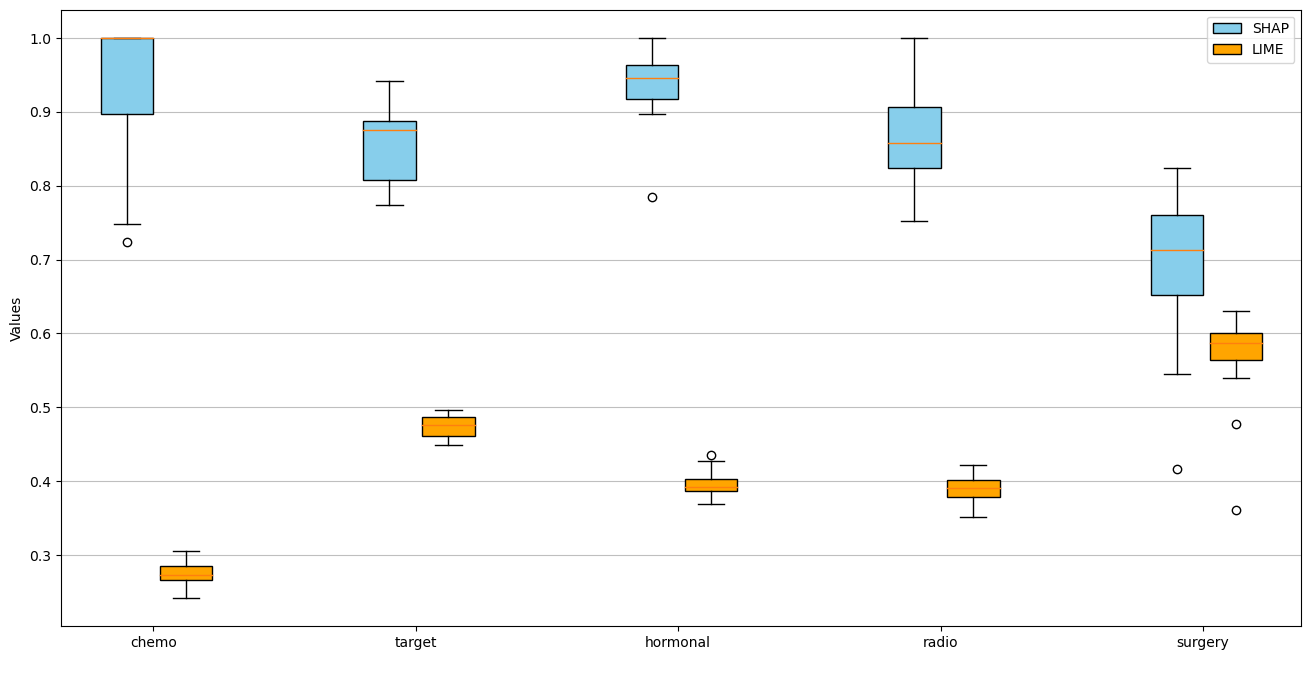

In [17]:
warnings.filterwarnings('ignore')
data, X, Y, classes_names = data_read_function( )
fidelity_Plot_Data={}
Treatments=['chemo','target','hormonal','radio','surgery']
for treatment_name in Treatments :
    Fidelity_Plot_Data= Lime_Shap_fidelity(data, X, Y, classes_names, fidelity_Plot_Data, treatment_name)
    
colors = ['skyblue', 'orange'] # Bar colors in plot
Plot_the_data(Fidelity_Plot_Data, colors)

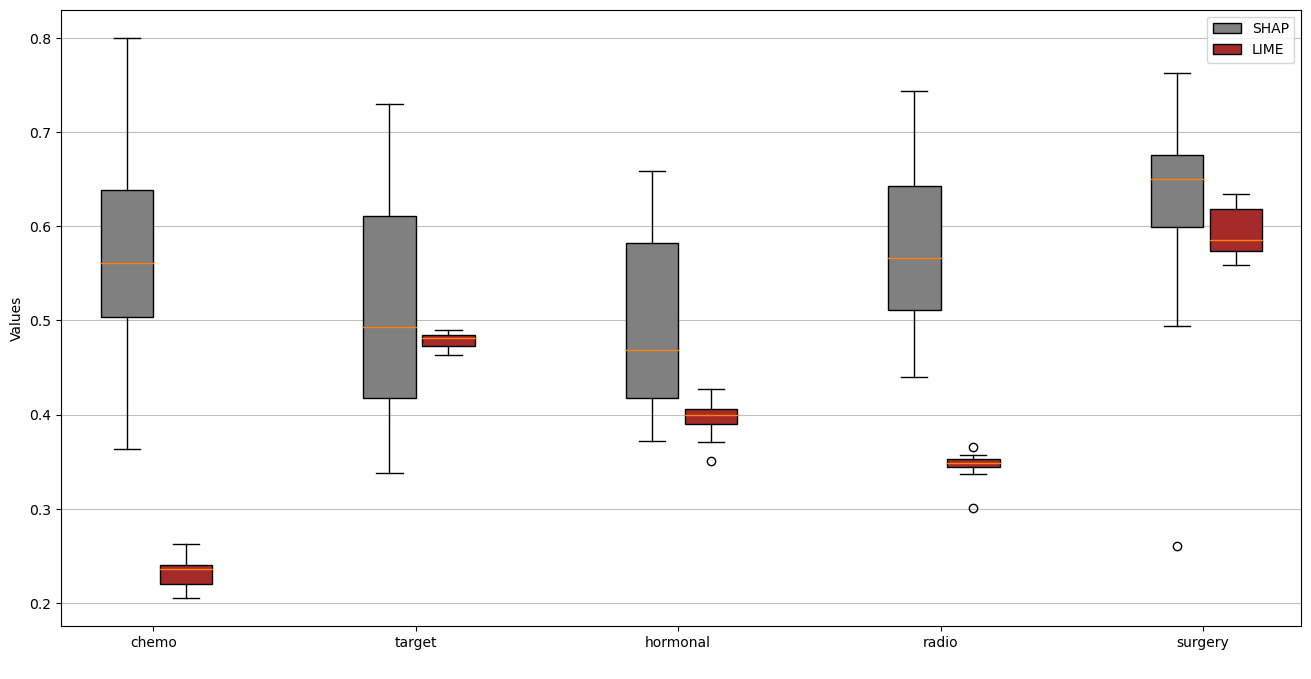

In [981]:
colors = ['gray', 'brown']
Plot_the_data(Fidelity_Plot_Data, colors )

# LIME and SHAP stability

In [13]:
import itertools

def concordance(pair):
    """Function to calculate the concordance of a pair of explanations."""
    g1, g2 = pair
    return len(set(g1).intersection(set(g2)))

def calculate_vsi(explanations):
    """Calculate the Variance Score Index (VSI) from LIME explanations."""
    m = len(explanations)
    n = 0
    p = len(explanations[0])  # Assuming all explanations have the same length

    # Generate all pairs of explanations
    pairs = list(itertools.combinations(explanations, 2))

    # Calculate the sum of concordances
    for pair in pairs:
        n += concordance(pair) / p

    # Calculate the total number of pairs
    total_pairs = len(pairs)

    # Calculate VSI
    vsi = n / total_pairs
    return vsi



def lime_vsi_fucntion(rf, x_train, x_test, y_test, data_row, sample):

    
    Predicted_class= rf.predict(sample)[0]
    
        #Lime Explainer
    LIME_explainer = LimeTabularExplainer(x_train.values, 
                                 feature_names=x_train.columns, 
                                 class_names=classes_names[y_test.name], 
                                 discretize_continuous=True, verbose=True)


    Lime_Explanations= []


    for _ in range(3): #generate 3 time explaination of same instance and compare them

        ##############. Lime  #################
        LIME_explanation = LIME_explainer.explain_instance(sample[0], rf .predict_proba, num_features=46, num_samples=2000, top_labels=5)
        lime_values_of_Prid_cls= LIME_explanation.local_exp[Predicted_class]
        column_names=x_train.columns
        positive_list = [(x, y) for x, y in lime_values_of_Prid_cls if y > 0]
        # Separate the x and y values
        x_values = [x for x, y in positive_list]
        x_names = [column_names[t] for t in x_values]
        y_values = [y for x, y in positive_list]

        # Combine x_names and y_values into a list of tuples and sort by y_values
        sorted_list = sorted(zip(x_names, y_values), key=lambda pair: pair[1], reverse=True)

        # Unzip the sorted list
        x_names_sorted, y_values_sorted = zip(*sorted_list)
        top_five_features = x_names_sorted[:10] #selected top 10
        Lime_Explanations.append(top_five_features)

    Lime_vsi = calculate_vsi(Lime_Explanations)
    
    return Lime_vsi




def shap_vsi_fucntion(rf, x_train, x_test, y_test, data_row, sample):
    #Instances =np.random.randint(100, size=(10)) #randomly pick 10 instances from data (in the range of 100 intances)

    Predicted_class= rf.predict(sample)[0]
    

    Shap_Explanations= []
    
            #Shap Explainer 

    # Define the number of samples to summarize the background data
    K = 100  # Choose an appropriate value for K

    # Summarize the background data using shap.sample()
    background_sample = shap.sample(x_train, K)

    # Use the summarized background sample in your SHAP model
    #Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample, link = 'logit')
    Shap_explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample)


    for _ in range(3): #generate 3 time explaination of same instance and compare them

        #############. Shap  #####################
        shap_values_single_instance = Shap_explainer.shap_values(data_row, nsamples=2000, l1_reg="num_features(46)")

        # Provided SHAP values and column names
        #shap_valuesss = shap_values_single_instance[Predicted_class][0]
        shap_valuesss = np.abs(shap_values_single_instance).mean(axis=0).mean(axis=0)
        column_namesss = x_train.columns
        # Flatten shap_values array
        #shap_values = shap_values.flatten()

        # Filter positive SHAP values
        positive_shap_indices = np.where(shap_valuesss > 0)[0]
        positive_shap_values = shap_valuesss[positive_shap_indices]
        positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

        # Combine and sort by SHAP values
        positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
        positive_shap_list.sort(key=lambda x: x[1], reverse=True)

        # Select top 20
        top_5_shap = positive_shap_list[:10] #top 10
        # Unzip to get column names and values
        top_5_columns, top_5_values = zip(*top_5_shap)
        Shap_Explanations.append(top_5_columns)

    Shap_vsi= calculate_vsi(Shap_Explanations)
    
    return Shap_vsi


        
def Lime_Shap_stability(data, X, Y, classes_names, stability_Plot_Data, treatment_name): 
    warnings.filterwarnings('ignore')

    Shap_VSI=[]
    Lime_VSI=[]
    #for _ in range(5):

    y=Y[treatment_name]

    smote = SMOTE(random_state=42)

    X_class_resampled, y_class_resampled = smote.fit_resample(X , y)

    X_class_resampled.replace({False: 0, True: 1}, inplace=True)
    y_class_resampled.replace({False:0, True:1}, inplace= True)

    x_train,x_test,y_train,y_test=train_test_split(X_class_resampled,y_class_resampled,test_size=0.2)

    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    #X_res, y_res = sm.fit_resample(x_train, y_train)

    #Randomforest Classifier
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    


    # Explanation over 20 single points 

    #j=np.random.randint(1000, size=(20)) #randomly pick 20 instances from data (in the range of 1000 intances)

    j_list= computing_j (rf, x_test, y_test)[:10]
    
    for j in j_list :
        data_row = x_test.iloc[[j], :] #single instance from the test dataset
        sample =data_row.values.reshape(1, -1)
        
        shap_vsi = shap_vsi_fucntion(rf, x_train, x_test, y_test, data_row, sample)
        lime_vsi = lime_vsi_fucntion(rf,x_train, x_test, y_test, data_row, sample)
        Shap_VSI.append(shap_vsi)
        Lime_VSI.append(lime_vsi)
        
    stability_Plot_Data[treatment_name]=[Shap_VSI, Lime_VSI]
    
    return stability_Plot_Data
    
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11010987544226057
Prediction_local [0.04280678]
Right: 0.0
Intercept 0.70569336306704
Prediction_local [0.06918061]
Right: 0.0
Intercept -0.028443057002191602
Prediction_local [0.18275971]
Right: 0.1
Intercept -0.11628941725822156
Prediction_local [0.31729697]
Right: 0.14
Intercept 0.3292180448631939
Prediction_local [0.38792792]
Right: 0.76
Intercept 0.06705469190400157
Prediction_local [0.04890693]
Right: 0.0
Intercept 0.7509030456707106
Prediction_local [0.06816041]
Right: 0.0
Intercept -0.08000404389673638
Prediction_local [0.16540086]
Right: 0.1
Intercept -0.070472099891766
Prediction_local [0.31716527]
Right: 0.14
Intercept 0.3297079689030097
Prediction_local [0.40069499]
Right: 0.76
Intercept 0.11207900527892183
Prediction_local [0.04430339]
Right: 0.0
Intercept 0.7108118239758956
Prediction_local [0.0720185]
Right: 0.0
Intercept -0.06311536947335081
Prediction_local [0.17230154]
Right: 0.1
Intercept -0.11040737700607112
Prediction_local [0.32214927]
Right: 0.14
Inte

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04819578386762802
Prediction_local [0.18780271]
Right: 0.04
Intercept 0.663151988667493
Prediction_local [0.08140934]
Right: 0.04
Intercept 0.1147762907861567
Prediction_local [0.02948362]
Right: 0.13266666666666668
Intercept -0.15085401509457735
Prediction_local [0.3259747]
Right: 0.1416666666666667
Intercept 0.3231939364072564
Prediction_local [0.37589001]
Right: 0.6456666666666666
Intercept -0.02880647507971923
Prediction_local [0.1919101]
Right: 0.04
Intercept 0.7305887126165932
Prediction_local [0.0860082]
Right: 0.04
Intercept 0.11266753884516233
Prediction_local [0.0274119]
Right: 0.13266666666666668
Intercept -0.17533000612595873
Prediction_local [0.31621153]
Right: 0.1416666666666667
Intercept 0.36025968133935227
Prediction_local [0.37839113]
Right: 0.6456666666666666
Intercept 0.017946595722295955
Prediction_local [0.19078848]
Right: 0.04
Intercept 0.7475045815803465
Prediction_local [0.07708684]
Right: 0.04
Intercept 0.09739680964387061
Prediction_local [0.026675

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.010093626385520721
Prediction_local [0.17341666]
Right: 0.0
Intercept 0.6518048324271846
Prediction_local [0.17893707]
Right: 0.0
Intercept 0.11450408930969119
Prediction_local [0.01101763]
Right: 0.02
Intercept -0.15504918541904977
Prediction_local [0.31270724]
Right: 0.18
Intercept 0.37947963548450064
Prediction_local [0.32382729]
Right: 0.8
Intercept 0.040857849534882584
Prediction_local [0.17763356]
Right: 0.0
Intercept 0.6518750472025301
Prediction_local [0.17708475]
Right: 0.0
Intercept 0.08903889519563041
Prediction_local [0.00905401]
Right: 0.02
Intercept -0.1176417778719846
Prediction_local [0.30565058]
Right: 0.18
Intercept 0.3378429654534158
Prediction_local [0.33059549]
Right: 0.8
Intercept -0.030500189912340048
Prediction_local [0.18522651]
Right: 0.0
Intercept 0.7206738135040092
Prediction_local [0.17900076]
Right: 0.0
Intercept 0.0845975690034113
Prediction_local [0.00771494]
Right: 0.02
Intercept -0.17264450070988552
Prediction_local [0.30649656]
Right: 0.18

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.09007783883968393
Prediction_local [0.02616458]
Right: 0.0
Intercept 0.04746425443780597
Prediction_local [0.14625578]
Right: 0.0
Intercept 0.6790164410789921
Prediction_local [0.12728683]
Right: 0.0
Intercept -0.18580750321684053
Prediction_local [0.35351673]
Right: 0.01
Intercept 0.36812028627469284
Prediction_local [0.34742851]
Right: 0.99
Intercept 0.09661038022181026
Prediction_local [0.02894074]
Right: 0.0
Intercept -0.01606728924734216
Prediction_local [0.15017939]
Right: 0.0
Intercept 0.6937932135102437
Prediction_local [0.13348082]
Right: 0.0
Intercept -0.16166399904158846
Prediction_local [0.35119015]
Right: 0.01
Intercept 0.3885740201284449
Prediction_local [0.33613269]
Right: 0.99
Intercept 0.08114451674115246
Prediction_local [0.027096]
Right: 0.0
Intercept -0.05827876243628605
Prediction_local [0.15237895]
Right: 0.0
Intercept 0.677252480160317
Prediction_local [0.1446742]
Right: 0.0
Intercept -0.10904439381934145
Prediction_local [0.34621268]
Right: 0.01
Inte

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.023470442583174683
Prediction_local [0.13517205]
Right: 0.0
Intercept 0.0463187191907865
Prediction_local [0.05110471]
Right: 0.01
Intercept 0.6799990408743317
Prediction_local [0.13099485]
Right: 0.05
Intercept -0.09776897237153348
Prediction_local [0.29348544]
Right: 0.06
Intercept 0.346863467326518
Prediction_local [0.38940942]
Right: 0.88
Intercept -0.0009147315810942025
Prediction_local [0.14994163]
Right: 0.0
Intercept 0.10083895985048266
Prediction_local [0.04605331]
Right: 0.01
Intercept 0.6586811608876043
Prediction_local [0.13698673]
Right: 0.05
Intercept -0.15618808344604784
Prediction_local [0.27859119]
Right: 0.06
Intercept 0.3983049250901674
Prediction_local [0.38884865]
Right: 0.88
Intercept 0.05488911652363947
Prediction_local [0.13927619]
Right: 0.0
Intercept 0.0946110816162467
Prediction_local [0.04904366]
Right: 0.01
Intercept 0.6154790149029019
Prediction_local [0.13069908]
Right: 0.05
Intercept -0.16049428202075794
Prediction_local [0.29791537]
Right: 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.06977992315680127
Prediction_local [0.02289386]
Right: 0.01
Intercept 0.13485911310776494
Prediction_local [0.04449855]
Right: 0.05
Intercept 0.5664373299195445
Prediction_local [0.22180623]
Right: 0.17
Intercept -0.07933951742825274
Prediction_local [0.29169019]
Right: 0.18
Intercept 0.30832240050456095
Prediction_local [0.41877226]
Right: 0.59
Intercept 0.06606451666145062
Prediction_local [0.02763794]
Right: 0.01
Intercept 0.10345499787668307
Prediction_local [0.05997772]
Right: 0.05
Intercept 0.5545644221606235
Prediction_local [0.21920696]
Right: 0.17
Intercept -0.11910031653784053
Prediction_local [0.28274849]
Right: 0.18
Intercept 0.39388135399050633
Prediction_local [0.41076431]
Right: 0.59
Intercept 0.10412348713501274
Prediction_local [0.02455481]
Right: 0.01
Intercept 0.115645656141716
Prediction_local [0.04800306]
Right: 0.05
Intercept 0.5842057270604829
Prediction_local [0.23405595]
Right: 0.17
Intercept -0.10499283386886121
Prediction_local [0.29983046]
Right:

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.6908943702132853
Prediction_local [0.10825875]
Right: 0.03
Intercept -0.07590637737768322
Prediction_local [0.18433268]
Right: 0.05
Intercept 0.0957358271685243
Prediction_local [0.04967566]
Right: 0.12
Intercept -0.18620401965198063
Prediction_local [0.34587826]
Right: 0.14
Intercept 0.47565167580231404
Prediction_local [0.31182818]
Right: 0.66
Intercept 0.6870089342259313
Prediction_local [0.11633724]
Right: 0.03
Intercept 0.10252304717451378
Prediction_local [0.18343105]
Right: 0.05
Intercept 0.07113583773446297
Prediction_local [0.04968103]
Right: 0.12
Intercept -0.2736502704523741
Prediction_local [0.33827876]
Right: 0.14
Intercept 0.4148803706933519
Prediction_local [0.31198181]
Right: 0.66
Intercept 0.7194869505774996
Prediction_local [0.10504089]
Right: 0.03
Intercept 0.007488246571513785
Prediction_local [0.18757973]
Right: 0.05
Intercept 0.06707103669648948
Prediction_local [0.05050266]
Right: 0.12
Intercept -0.17053804476839174
Prediction_local [0.34727624]
Right

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08634134804652382
Prediction_local [0.06444662]
Right: 0.0
Intercept -0.227069536021637
Prediction_local [0.32099611]
Right: 0.0
Intercept 0.071397998095799
Prediction_local [0.11367728]
Right: 0.0
Intercept 0.7282465019187465
Prediction_local [0.11860692]
Right: 0.0
Intercept 0.34082705250508344
Prediction_local [0.38235756]
Right: 1.0
Intercept 0.049235788734367514
Prediction_local [0.06652569]
Right: 0.0
Intercept -0.11113528137891943
Prediction_local [0.32510083]
Right: 0.0
Intercept 0.061422930314834645
Prediction_local [0.10990257]
Right: 0.0
Intercept 0.608975131138807
Prediction_local [0.11947226]
Right: 0.0
Intercept 0.3912475971636759
Prediction_local [0.37810412]
Right: 1.0
Intercept 0.06117676709480517
Prediction_local [0.05793763]
Right: 0.0
Intercept -0.14443940803937
Prediction_local [0.29933219]
Right: 0.0
Intercept 0.12218574331712218
Prediction_local [0.12741291]
Right: 0.0
Intercept 0.6753031377912982
Prediction_local [0.11634517]
Right: 0.0
Intercept 0.2

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04764246291573596
Prediction_local [0.05629261]
Right: 0.06
Intercept 0.7282502267380409
Prediction_local [0.10144504]
Right: 0.08
Intercept -0.04356402107674079
Prediction_local [0.227665]
Right: 0.21
Intercept -0.17428422639974744
Prediction_local [0.30741896]
Right: 0.31
Intercept 0.4411054416875574
Prediction_local [0.30719392]
Right: 0.34
Intercept 0.049203059364231756
Prediction_local [0.05618888]
Right: 0.06
Intercept 0.7402014708139055
Prediction_local [0.10037307]
Right: 0.08
Intercept -0.0024270350891612558
Prediction_local [0.21491411]
Right: 0.21
Intercept -0.15147967197386386
Prediction_local [0.30532966]
Right: 0.31
Intercept 0.36549575112522803
Prediction_local [0.32287658]
Right: 0.34
Intercept 0.08161972444301116
Prediction_local [0.05570414]
Right: 0.06
Intercept 0.7757071307173847
Prediction_local [0.09929559]
Right: 0.08
Intercept -0.10751423289400214
Prediction_local [0.21432912]
Right: 0.21
Intercept -0.16872050772930142
Prediction_local [0.31224913]
R

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.09178843440707946
Prediction_local [0.17691521]
Right: 0.03
Intercept 0.689912236229745
Prediction_local [0.11466972]
Right: 0.06
Intercept 0.1250104227685148
Prediction_local [0.01075484]
Right: 0.08265476190476191
Intercept -0.139601417314352
Prediction_local [0.33498848]
Right: 0.17
Intercept 0.4179812597087278
Prediction_local [0.36266835]
Right: 0.657345238095238
Intercept 0.048639149984209096
Prediction_local [0.17707697]
Right: 0.03
Intercept 0.7212912190315529
Prediction_local [0.11630889]
Right: 0.06
Intercept 0.08257925942332794
Prediction_local [0.00998356]
Right: 0.08265476190476191
Intercept -0.16320131602518123
Prediction_local [0.33058449]
Right: 0.17
Intercept 0.31244328322944975
Prediction_local [0.36595621]
Right: 0.657345238095238
Intercept -0.037309182114463296
Prediction_local [0.17823884]
Right: 0.03
Intercept 0.7786997759031052
Prediction_local [0.1199508]
Right: 0.06
Intercept 0.07114292751901241
Prediction_local [0.01317403]
Right: 0.08265476190476

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08261605165414222
Prediction_local [0.06574938]
Right: 0.0
Intercept 0.3276893327611082
Prediction_local [0.28346531]
Right: 0.0
Intercept 0.11239124744503476
Prediction_local [0.10666641]
Right: 0.0
Intercept 0.14788314796421048
Prediction_local [0.2703536]
Right: 0.01
Intercept 0.3303270255313077
Prediction_local [0.27382203]
Right: 0.99
Intercept 0.1037120501602157
Prediction_local [0.07811187]
Right: 0.0
Intercept 0.28523383010912556
Prediction_local [0.2636495]
Right: 0.0
Intercept 0.09042365755321823
Prediction_local [0.11583337]
Right: 0.0
Intercept 0.1487170479938661
Prediction_local [0.27214438]
Right: 0.01
Intercept 0.37115728580191054
Prediction_local [0.27054989]
Right: 0.99
Intercept 0.0842860560060898
Prediction_local [0.06758573]
Right: 0.0
Intercept 0.28524929889867023
Prediction_local [0.26121733]
Right: 0.0
Intercept 0.1450506983425373
Prediction_local [0.1104502]
Right: 0.0
Intercept 0.09805661442572575
Prediction_local [0.28216078]
Right: 0.01
Intercept 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.02512794071935577
Prediction_local [0.0675543]
Right: 0.0
Intercept 0.08920255914667347
Prediction_local [0.1090535]
Right: 0.01
Intercept 0.2572716137120564
Prediction_local [0.21889262]
Right: 0.05
Intercept 0.2688166690399491
Prediction_local [0.30488581]
Right: 0.06
Intercept 0.36127701216030583
Prediction_local [0.29931806]
Right: 0.88
Intercept 0.11925923391753995
Prediction_local [0.07054182]
Right: 0.0
Intercept 0.11598256423392443
Prediction_local [0.10792812]
Right: 0.01
Intercept 0.09818024835482739
Prediction_local [0.24257486]
Right: 0.05
Intercept 0.28710721823442675
Prediction_local [0.29082334]
Right: 0.06
Intercept 0.37962445912651516
Prediction_local [0.28846056]
Right: 0.88
Intercept 0.029545419752868403
Prediction_local [0.06651385]
Right: 0.0
Intercept 0.18034793422535664
Prediction_local [0.11537175]
Right: 0.01
Intercept 0.22786399275456898
Prediction_local [0.24095157]
Right: 0.05
Intercept 0.23759036090641614
Prediction_local [0.30113575]
Right: 0.0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.13148461592962943
Prediction_local [-0.01122319]
Right: 0.0
Intercept 0.2910551444060465
Prediction_local [0.3084568]
Right: 0.0
Intercept -0.00924151485549568
Prediction_local [0.15239602]
Right: 0.0
Intercept 0.23292571419125377
Prediction_local [0.24324869]
Right: 0.03
Intercept 0.3536048431886783
Prediction_local [0.3070212]
Right: 0.97
Intercept 0.23811676157214273
Prediction_local [-0.02162948]
Right: 0.0
Intercept 0.2584836033614269
Prediction_local [0.31004985]
Right: 0.0
Intercept 0.040022726686405816
Prediction_local [0.1554974]
Right: 0.0
Intercept 0.17863865688770686
Prediction_local [0.25622236]
Right: 0.03
Intercept 0.2843680479865157
Prediction_local [0.30008224]
Right: 0.97
Intercept 0.16143721425022514
Prediction_local [-0.01465642]
Right: 0.0
Intercept 0.23431706974692287
Prediction_local [0.30568485]
Right: 0.0
Intercept 0.05709424876212406
Prediction_local [0.15436507]
Right: 0.0
Intercept 0.2445987246858096
Prediction_local [0.24934521]
Right: 0.03
Inte

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04044547701725831
Prediction_local [0.07888072]
Right: 0.0
Intercept 0.17262062707628587
Prediction_local [0.0725455]
Right: 0.01
Intercept 0.13736801861792516
Prediction_local [0.29284972]
Right: 0.04
Intercept 0.29911773723097757
Prediction_local [0.30530556]
Right: 0.08
Intercept 0.350209966999464
Prediction_local [0.2504443]
Right: 0.87
Intercept 0.061331930894104145
Prediction_local [0.06263956]
Right: 0.0
Intercept 0.12834685107809957
Prediction_local [0.07929245]
Right: 0.01
Intercept 0.16194953495450717
Prediction_local [0.29380382]
Right: 0.04
Intercept 0.2828595671378714
Prediction_local [0.30915606]
Right: 0.08
Intercept 0.36657565558190996
Prediction_local [0.25490533]
Right: 0.87
Intercept 0.04695956654395363
Prediction_local [0.06165386]
Right: 0.0
Intercept 0.21321358275967878
Prediction_local [0.09173583]
Right: 0.01
Intercept 0.08538621902617521
Prediction_local [0.28990048]
Right: 0.04
Intercept 0.26295544016220984
Prediction_local [0.31047064]
Right: 0.08

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07510404707453776
Prediction_local [0.01100097]
Right: 0.0
Intercept 0.1712344632140165
Prediction_local [0.11200167]
Right: 0.0
Intercept 0.2217727616410236
Prediction_local [0.24350122]
Right: 0.03
Intercept 0.2727752630785099
Prediction_local [0.28783306]
Right: 0.07
Intercept 0.2583825046116211
Prediction_local [0.34589045]
Right: 0.9
Intercept 0.18674518893715808
Prediction_local [0.00720955]
Right: 0.0
Intercept 0.08915659955457518
Prediction_local [0.12003951]
Right: 0.0
Intercept 0.14986185858002365
Prediction_local [0.25274054]
Right: 0.03
Intercept 0.3402936892538561
Prediction_local [0.28211376]
Right: 0.07
Intercept 0.23368540630317597
Prediction_local [0.33752219]
Right: 0.9
Intercept 0.13607876791940282
Prediction_local [0.00834169]
Right: 0.0
Intercept 0.1552948732796077
Prediction_local [0.10669768]
Right: 0.0
Intercept 0.12246336899406526
Prediction_local [0.24140004]
Right: 0.03
Intercept 0.3094740567346991
Prediction_local [0.28619396]
Right: 0.07
Interce

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.005621062213460856
Prediction_local [0.06651047]
Right: 0.0
Intercept 0.23660699839890972
Prediction_local [0.25158521]
Right: 0.0
Intercept 0.3637495627823777
Prediction_local [0.32409264]
Right: 0.0
Intercept 0.09626142241609437
Prediction_local [0.06897572]
Right: 0.0
Intercept 0.2982133560392831
Prediction_local [0.28866749]
Right: 1.0
Intercept 0.12456772300808508
Prediction_local [0.04956007]
Right: 0.0
Intercept 0.13096488135373707
Prediction_local [0.25431663]
Right: 0.0
Intercept 0.2871316172078778
Prediction_local [0.35006384]
Right: 0.0
Intercept 0.060973652834658845
Prediction_local [0.08737525]
Right: 0.0
Intercept 0.3962888444429433
Prediction_local [0.25869961]
Right: 1.0
Intercept 0.1301319413969066
Prediction_local [0.06709698]
Right: 0.0
Intercept 0.08406381526435663
Prediction_local [0.23578527]
Right: 0.0
Intercept 0.19891931723138462
Prediction_local [0.33324877]
Right: 0.0
Intercept 0.2050104559826546
Prediction_local [0.08274394]
Right: 0.0
Intercept 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.11507420854551317
Prediction_local [0.00607898]
Right: 0.01
Intercept 0.15356655266858132
Prediction_local [0.13095249]
Right: 0.01
Intercept 0.2880702885303337
Prediction_local [0.30922531]
Right: 0.02
Intercept 0.12043204485762454
Prediction_local [0.2716463]
Right: 0.03
Intercept 0.3230443641357491
Prediction_local [0.2820941]
Right: 0.93
Intercept 0.12118106189556507
Prediction_local [0.01121953]
Right: 0.01
Intercept 0.16192178218582925
Prediction_local [0.1398459]
Right: 0.01
Intercept 0.2195656393859572
Prediction_local [0.29965084]
Right: 0.02
Intercept 0.15510720623592147
Prediction_local [0.26789121]
Right: 0.03
Intercept 0.34179288671392916
Prediction_local [0.28190985]
Right: 0.93
Intercept 0.11753501061870025
Prediction_local [0.0070899]
Right: 0.01
Intercept 0.11153097392778699
Prediction_local [0.14538546]
Right: 0.01
Intercept 0.3030206695506561
Prediction_local [0.30100227]
Right: 0.02
Intercept 0.08431748267624015
Prediction_local [0.2825566]
Right: 0.03
I

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04551136403775427
Prediction_local [0.03990202]
Right: 0.0
Intercept 0.10876485841877914
Prediction_local [0.26251597]
Right: 0.0
Intercept 0.3888294317648239
Prediction_local [0.2938144]
Right: 0.0
Intercept 0.11838231463029411
Prediction_local [0.11463068]
Right: 0.0
Intercept 0.3384990175912659
Prediction_local [0.28998532]
Right: 1.0
Intercept 0.059618872463954364
Prediction_local [0.04319976]
Right: 0.0
Intercept 0.18931012568823785
Prediction_local [0.26456165]
Right: 0.0
Intercept 0.31325759335744496
Prediction_local [0.28493147]
Right: 0.0
Intercept 0.14429550692170498
Prediction_local [0.11439451]
Right: 0.0
Intercept 0.2929711089571737
Prediction_local [0.29295518]
Right: 1.0
Intercept 0.05825092790940911
Prediction_local [0.04887349]
Right: 0.0
Intercept 0.16591885516976757
Prediction_local [0.26011146]
Right: 0.0
Intercept 0.2629807257151264
Prediction_local [0.30227807]
Right: 0.0
Intercept 0.17939949724953197
Prediction_local [0.10501412]
Right: 0.0
Intercept 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.07722172259954047
Prediction_local [0.1487862]
Right: 0.0
Intercept 0.33838115433852556
Prediction_local [0.23743556]
Right: 0.0
Intercept 0.10416188257018022
Prediction_local [0.12745797]
Right: 0.0
Intercept 0.1301683844326687
Prediction_local [0.30202264]
Right: 0.03
Intercept 0.5039833506961406
Prediction_local [0.18433907]
Right: 0.97
Intercept -0.03936410762913142
Prediction_local [0.15596999]
Right: 0.0
Intercept 0.3084545351675391
Prediction_local [0.24032342]
Right: 0.0
Intercept 0.16531942832153712
Prediction_local [0.12418036]
Right: 0.0
Intercept 0.1639898212716232
Prediction_local [0.29592033]
Right: 0.03
Intercept 0.4021628807024792
Prediction_local [0.18356901]
Right: 0.97
Intercept 0.05153426110574352
Prediction_local [0.14587439]
Right: 0.0
Intercept 0.3992393463463525
Prediction_local [0.23937905]
Right: 0.0
Intercept -0.007292186673673567
Prediction_local [0.13250608]
Right: 0.0
Intercept 0.16268096995702402
Prediction_local [0.29495485]
Right: 0.03
Inte

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08953236137717985
Prediction_local [0.02442881]
Right: 0.0
Intercept 0.11362551343886373
Prediction_local [0.27953172]
Right: 0.0
Intercept 0.4470926135026649
Prediction_local [0.2438963]
Right: 0.0
Intercept -0.025937256866819886
Prediction_local [0.23354242]
Right: 0.0
Intercept 0.37590545755706783
Prediction_local [0.2185231]
Right: 1.0
Intercept 0.16913982443178216
Prediction_local [-0.00436658]
Right: 0.0
Intercept 0.17028763038007005
Prediction_local [0.26577952]
Right: 0.0
Intercept 0.33870672165543386
Prediction_local [0.26274224]
Right: 0.0
Intercept -0.0885513168607372
Prediction_local [0.25351449]
Right: 0.0
Intercept 0.40941592424163065
Prediction_local [0.22231475]
Right: 1.0
Intercept 0.1445465049120739
Prediction_local [-0.0034191]
Right: 0.0
Intercept 0.13332141573735232
Prediction_local [0.27222704]
Right: 0.0
Intercept 0.376127728549961
Prediction_local [0.24647508]
Right: 0.0
Intercept -0.02052172563969537
Prediction_local [0.25938313]
Right: 0.0
Intercep

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.02105458481220797
Prediction_local [0.05262306]
Right: 0.0
Intercept -0.06775793511474183
Prediction_local [0.06186179]
Right: 0.0
Intercept 0.17605117721906044
Prediction_local [0.3452388]
Right: 0.0
Intercept 0.5941635808332447
Prediction_local [0.48694031]
Right: 0.0
Intercept 0.31791122475156436
Prediction_local [0.05311967]
Right: 1.0
Intercept -0.006082147884325553
Prediction_local [0.05321304]
Right: 0.0
Intercept -0.07115478030832459
Prediction_local [0.06889364]
Right: 0.0
Intercept 0.12486589631682354
Prediction_local [0.33461473]
Right: 0.0
Intercept 0.59396389509374
Prediction_local [0.48458939]
Right: 0.0
Intercept 0.35918533451657475
Prediction_local [0.05932026]
Right: 1.0
Intercept 0.012115145979641473
Prediction_local [0.05470619]
Right: 0.0
Intercept -0.033451069559392574
Prediction_local [0.07343931]
Right: 0.0
Intercept 0.0807690851638683
Prediction_local [0.34004087]
Right: 0.0
Intercept 0.6720236239983499
Prediction_local [0.4737147]
Right: 0.0
Interc

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.02149957515955231
Prediction_local [0.02014535]
Right: 0.0
Intercept 0.01726269300249473
Prediction_local [-0.00380348]
Right: 0.0
Intercept 0.36122448349884273
Prediction_local [0.10238396]
Right: 0.0
Intercept 0.473184269470476
Prediction_local [0.64647854]
Right: 0.0
Intercept 0.12777291570002886
Prediction_local [0.2350389]
Right: 1.0
Intercept 0.0499332069377513
Prediction_local [0.02948919]
Right: 0.0
Intercept 0.01498852183276067
Prediction_local [-0.02038925]
Right: 0.0
Intercept 0.2562910055851966
Prediction_local [0.14879175]
Right: 0.0
Intercept 0.5006980664515935
Prediction_local [0.55642183]
Right: 0.0
Intercept 0.17880192300811887
Prediction_local [0.28562195]
Right: 1.0
Intercept 0.034116127483805145
Prediction_local [0.02515341]
Right: 0.0
Intercept 0.04857227459228415
Prediction_local [-0.01255363]
Right: 0.0
Intercept 0.34003275509948044
Prediction_local [0.09663526]
Right: 0.0
Intercept 0.5038538052111441
Prediction_local [0.58295206]
Right: 0.0
Intercept

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.07298130876522696
Prediction_local [0.1180135]
Right: 0.0
Intercept -0.06148144891669551
Prediction_local [0.09501505]
Right: 0.0
Intercept 0.24525569351989254
Prediction_local [0.17909013]
Right: 0.0
Intercept 0.6974354764305788
Prediction_local [0.45915571]
Right: 0.0
Intercept 0.19280066942240734
Prediction_local [0.14872211]
Right: 1.0
Intercept -0.014553092433072845
Prediction_local [0.10773233]
Right: 0.0
Intercept -0.05612937137224352
Prediction_local [0.10979357]
Right: 0.0
Intercept 0.28135930085413213
Prediction_local [0.16445983]
Right: 0.0
Intercept 0.6104886787603331
Prediction_local [0.47572398]
Right: 0.0
Intercept 0.17949019725689253
Prediction_local [0.14201138]
Right: 1.0
Intercept -0.030117086029327084
Prediction_local [0.10467654]
Right: 0.0
Intercept -0.10679406746395219
Prediction_local [0.09614761]
Right: 0.0
Intercept 0.31434373643513785
Prediction_local [0.18476379]
Right: 0.0
Intercept 0.6279113994637157
Prediction_local [0.46889116]
Right: 0.0
In

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.04109319762212424
Prediction_local [0.02799409]
Right: 0.0
Intercept 0.05634159333604221
Prediction_local [0.00639406]
Right: 0.0
Intercept 0.3836341027456835
Prediction_local [0.06655207]
Right: 0.0
Intercept 0.4679575355846544
Prediction_local [0.61528156]
Right: 0.0
Intercept 0.05290156162107196
Prediction_local [0.28340889]
Right: 1.0
Intercept 0.08525775177141187
Prediction_local [0.02180733]
Right: 0.0
Intercept 0.023031328787910935
Prediction_local [-0.0040101]
Right: 0.0
Intercept 0.44578542808609045
Prediction_local [0.06980208]
Right: 0.0
Intercept 0.4363398806044352
Prediction_local [0.61560051]
Right: 0.0
Intercept 0.00871420415017378
Prediction_local [0.29724183]
Right: 1.0
Intercept 0.06303746884863162
Prediction_local [0.00503299]
Right: 0.0
Intercept 0.0018049792505460682
Prediction_local [-0.00853411]
Right: 0.0
Intercept 0.4157981707470495
Prediction_local [0.07861496]
Right: 0.0
Intercept 0.5057242936279389
Prediction_local [0.62754422]
Right: 0.0
Interce

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.003034933720234251
Prediction_local [0.05074254]
Right: 0.0
Intercept 0.028965463358212547
Prediction_local [-0.00209334]
Right: 0.0
Intercept 0.2676335568204155
Prediction_local [0.14455694]
Right: 0.0
Intercept 0.6710926148853236
Prediction_local [0.51223921]
Right: 0.03
Intercept 0.02964312528355839
Prediction_local [0.29456046]
Right: 0.97
Intercept -0.02692160590356421
Prediction_local [0.05342465]
Right: 0.0
Intercept -0.009730813827043085
Prediction_local [0.00820384]
Right: 0.0
Intercept 0.3482759393996036
Prediction_local [0.13206804]
Right: 0.0
Intercept 0.6663822121895149
Prediction_local [0.5168839]
Right: 0.03
Intercept 0.023479831148361274
Prediction_local [0.28947107]
Right: 0.97
Intercept 0.08438084478818811
Prediction_local [0.06261666]
Right: 0.0
Intercept -0.00451509917550573
Prediction_local [0.02082673]
Right: 0.0
Intercept 0.2696991682589389
Prediction_local [0.11302605]
Right: 0.0
Intercept 0.5685386435903763
Prediction_local [0.52624366]
Right: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.060804340203705974
Prediction_local [0.11742707]
Right: 0.0
Intercept 0.19031362327226456
Prediction_local [0.3145707]
Right: 0.0
Intercept 0.6607533392637915
Prediction_local [0.44183642]
Right: 0.0
Intercept -0.021334053116022336
Prediction_local [0.10818306]
Right: 0.05897693242629302
Intercept 0.23102350633453736
Prediction_local [0.01779461]
Right: 0.9410230675737065
Intercept -0.046152049837855584
Prediction_local [0.11558975]
Right: 0.0
Intercept 0.10883560143791057
Prediction_local [0.3147916]
Right: 0.0
Intercept 0.6336829151235709
Prediction_local [0.4345477]
Right: 0.0
Intercept -0.036774646011473386
Prediction_local [0.1085687]
Right: 0.05897693242629302
Intercept 0.341027262550327
Prediction_local [0.02661757]
Right: 0.9410230675737065
Intercept -0.07903767841427105
Prediction_local [0.1127135]
Right: 0.0
Intercept 0.12230932734828334
Prediction_local [0.31787322]
Right: 0.0
Intercept 0.7559636318081897
Prediction_local [0.43658843]
Right: 0.0
Intercept -0.068

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.008974299337155434
Prediction_local [0.05953242]
Right: 0.0
Intercept 0.06452978763052108
Prediction_local [-0.01806208]
Right: 0.0
Intercept 0.013157464086833104
Prediction_local [0.42939558]
Right: 0.0
Intercept 0.7719345449197474
Prediction_local [0.40016547]
Right: 0.0
Intercept 0.1423344250853651
Prediction_local [0.12892279]
Right: 1.0
Intercept 0.02142002893873632
Prediction_local [0.05932519]
Right: 0.0
Intercept 0.10241887061635478
Prediction_local [-0.02001141]
Right: 0.0
Intercept 0.010800321788289824
Prediction_local [0.43587836]
Right: 0.0
Intercept 0.7152186821744497
Prediction_local [0.39797767]
Right: 0.0
Intercept 0.15015680864629877
Prediction_local [0.12675924]
Right: 1.0
Intercept 0.024689005174650586
Prediction_local [0.06326782]
Right: 0.0
Intercept 0.10393842584649116
Prediction_local [-0.02258353]
Right: 0.0
Intercept 0.06449435611959325
Prediction_local [0.42222041]
Right: 0.0
Intercept 0.7068570545839111
Prediction_local [0.39923257]
Right: 0.0
Int

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.009601297485567532
Prediction_local [0.04130274]
Right: 0.0
Intercept -0.0783489788635762
Prediction_local [0.1240787]
Right: 0.02
Intercept 0.10564393739698605
Prediction_local [0.3199047]
Right: 0.02
Intercept 0.8620313004432549
Prediction_local [0.33335845]
Right: 0.06
Intercept 0.1184772433451005
Prediction_local [0.1814724]
Right: 0.9
Intercept -0.020347435194619415
Prediction_local [0.04167044]
Right: 0.0
Intercept -0.04146241727347923
Prediction_local [0.12105851]
Right: 0.02
Intercept 0.14552352595837909
Prediction_local [0.31295162]
Right: 0.02
Intercept 0.7461332330280294
Prediction_local [0.35196649]
Right: 0.06
Intercept 0.17030827964519332
Prediction_local [0.17232979]
Right: 0.9
Intercept 0.040781802042637205
Prediction_local [0.03692586]
Right: 0.0
Intercept -0.08063337654251494
Prediction_local [0.12168587]
Right: 0.02
Intercept 0.13814816554342896
Prediction_local [0.31497328]
Right: 0.02
Intercept 0.7838896010074244
Prediction_local [0.34335591]
Right: 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.011275419635923753
Prediction_local [0.13531386]
Right: 0.0
Intercept -0.027019314682583256
Prediction_local [0.06934136]
Right: 0.0
Intercept 0.1203263796768021
Prediction_local [0.30658609]
Right: 0.0
Intercept 0.7483460726499789
Prediction_local [0.34544427]
Right: 0.0
Intercept 0.1684637126582838
Prediction_local [0.1440684]
Right: 1.0
Intercept -0.05193362552288028
Prediction_local [0.12782042]
Right: 0.0
Intercept -0.011851935661544265
Prediction_local [0.05839472]
Right: 0.0
Intercept 0.10584102750328556
Prediction_local [0.32346031]
Right: 0.0
Intercept 0.7855681695785208
Prediction_local [0.34572231]
Right: 0.0
Intercept 0.17090183306196782
Prediction_local [0.14463252]
Right: 1.0
Intercept -0.05274104614528227
Prediction_local [0.12325108]
Right: 0.0
Intercept -0.021861111661965762
Prediction_local [0.06421554]
Right: 0.0
Intercept 0.15974665148591302
Prediction_local [0.32018186]
Right: 0.0
Intercept 0.7009383106660312
Prediction_local [0.35852071]
Right: 0.0
In

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.07442334651446195
Prediction_local [0.13032899]
Right: 0.0
Intercept -0.03352093333553504
Prediction_local [0.05019196]
Right: 0.0
Intercept 0.12052966441816149
Prediction_local [0.29871914]
Right: 0.0
Intercept 0.8352827992224912
Prediction_local [0.35577634]
Right: 0.0
Intercept 0.1527792441149765
Prediction_local [0.16494731]
Right: 1.0
Intercept -0.08906655979382519
Prediction_local [0.14054258]
Right: 0.0
Intercept -0.03012194617158631
Prediction_local [0.05014335]
Right: 0.0
Intercept 0.12446578071914896
Prediction_local [0.30552814]
Right: 0.0
Intercept 0.776539422285415
Prediction_local [0.34623122]
Right: 0.0
Intercept 0.2209017861300928
Prediction_local [0.15724119]
Right: 1.0
Intercept -0.06056554723998843
Prediction_local [0.13600632]
Right: 0.0
Intercept 0.004653607777795846
Prediction_local [0.05426436]
Right: 0.0
Intercept 0.1799804026580809
Prediction_local [0.30256356]
Right: 0.0
Intercept 0.672730958706196
Prediction_local [0.35299292]
Right: 0.0
Intercep

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.18165862905734637
Prediction_local [0.45451473]
Right: 0.0
Intercept 0.07158764971684628
Prediction_local [0.05099506]
Right: 0.0
Intercept 0.6899562597274311
Prediction_local [0.21649441]
Right: 0.0
Intercept 0.05624765386581823
Prediction_local [0.27798314]
Right: 1.0
Intercept 0.18988587125671227
Prediction_local [0.43547448]
Right: 0.0
Intercept 0.06014562830328685
Prediction_local [0.04852375]
Right: 0.0
Intercept 0.7214005169393934
Prediction_local [0.21848767]
Right: 0.0
Intercept 0.03028001506292305
Prediction_local [0.29770778]
Right: 1.0
Intercept 0.11406605111150692
Prediction_local [0.44647604]
Right: 0.0
Intercept 0.08045779539231426
Prediction_local [0.06473847]
Right: 0.0
Intercept 0.8161029387857356
Prediction_local [0.20035307]
Right: 0.0
Intercept -0.011311200859906612
Prediction_local [0.28800691]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.19036558428172873
Prediction_local [0.40343737]
Right: 0.0
Intercept 0.08718303073172864
Prediction_local [0.00804553]
Right: 0.0
Intercept 0.7140999452706671
Prediction_local [0.27591803]
Right: 0.01
Intercept 0.010795193483978005
Prediction_local [0.3120832]
Right: 0.99
Intercept 0.23759615415485014
Prediction_local [0.39577051]
Right: 0.0
Intercept 0.08575025654665472
Prediction_local [0.00322066]
Right: 0.0
Intercept 0.5858374507795062
Prediction_local [0.29123052]
Right: 0.01
Intercept 0.09002693394181607
Prediction_local [0.30976004]
Right: 0.99
Intercept 0.16941411373146745
Prediction_local [0.40151894]
Right: 0.0
Intercept 0.08456030056839683
Prediction_local [0.00465367]
Right: 0.0
Intercept 0.7109219302962622
Prediction_local [0.29271294]
Right: 0.01
Intercept 0.03537957783763607
Prediction_local [0.30062608]
Right: 0.99


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.12208816989563254
Prediction_local [0.00460526]
Right: 0.006
Intercept 0.3639227444357484
Prediction_local [0.27330588]
Right: 0.10400000000000001
Intercept 0.5847643196053827
Prediction_local [0.37816294]
Right: 0.18
Intercept -0.07066299004590504
Prediction_local [0.34450916]
Right: 0.71
Intercept 0.055282407967140124
Prediction_local [0.0051594]
Right: 0.006
Intercept 0.22904751162503675
Prediction_local [0.28391408]
Right: 0.10400000000000001
Intercept 0.6221405333967884
Prediction_local [0.36823638]
Right: 0.18
Intercept 0.09266227934524923
Prediction_local [0.34268776]
Right: 0.71
Intercept 0.07604634551289105
Prediction_local [0.01193725]
Right: 0.006
Intercept 0.3768788944547228
Prediction_local [0.29037415]
Right: 0.10400000000000001
Intercept 0.6415114429542141
Prediction_local [0.36598321]
Right: 0.18
Intercept -0.0954654398541282
Prediction_local [0.33061971]
Right: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07971138800977051
Prediction_local [0.03368774]
Right: 0.0
Intercept 0.26319447056596124
Prediction_local [0.33484418]
Right: 0.02
Intercept 0.642312592639648
Prediction_local [0.28511142]
Right: 0.05
Intercept 0.01605443751565533
Prediction_local [0.34602448]
Right: 0.93
Intercept 0.07923689221602809
Prediction_local [0.03444042]
Right: 0.0
Intercept 0.1860011280845966
Prediction_local [0.33848076]
Right: 0.02
Intercept 0.6781281952739173
Prediction_local [0.27156304]
Right: 0.05
Intercept 0.057115940163728396
Prediction_local [0.35550206]
Right: 0.93
Intercept 0.08886414295638335
Prediction_local [0.03082415]
Right: 0.0
Intercept 0.24246891426960704
Prediction_local [0.34229437]
Right: 0.02
Intercept 0.6133747170301813
Prediction_local [0.27391535]
Right: 0.05
Intercept 0.05692703505020871
Prediction_local [0.35293423]
Right: 0.93


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10562750180455294
Prediction_local [0.01344809]
Right: 0.0
Intercept 0.5881705790141823
Prediction_local [0.29150983]
Right: 0.0
Intercept 0.3464766101454744
Prediction_local [0.3421382]
Right: 0.03
Intercept -0.040935469349579146
Prediction_local [0.35296361]
Right: 0.97
Intercept 0.1084028677973122
Prediction_local [0.0111632]
Right: 0.0
Intercept 0.6868372630339907
Prediction_local [0.29151801]
Right: 0.0
Intercept 0.27188040074267295
Prediction_local [0.33364897]
Right: 0.03
Intercept -0.06864514698271501
Prediction_local [0.36373249]
Right: 0.97
Intercept 0.13113385504217726
Prediction_local [0.01232272]
Right: 0.0
Intercept 0.7703928483008518
Prediction_local [0.28479882]
Right: 0.0
Intercept 0.20161860912199364
Prediction_local [0.34508503]
Right: 0.03
Intercept -0.10314481410656207
Prediction_local [0.35772967]
Right: 0.97


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1015257048071023
Prediction_local [0.02848789]
Right: 0.0
Intercept 0.24447127410436612
Prediction_local [0.35678509]
Right: 0.01
Intercept 0.7060047479735043
Prediction_local [0.2838566]
Right: 0.01
Intercept -0.05222690926720186
Prediction_local [0.33082894]
Right: 0.98
Intercept 0.08367027981577121
Prediction_local [0.02668298]
Right: 0.0
Intercept 0.297299244467885
Prediction_local [0.35020104]
Right: 0.01
Intercept 0.6385935319468816
Prediction_local [0.30141241]
Right: 0.01
Intercept -0.01904188636276649
Prediction_local [0.32165124]
Right: 0.98
Intercept 0.06564802114084654
Prediction_local [0.03332229]
Right: 0.0
Intercept 0.25198102207347894
Prediction_local [0.35924556]
Right: 0.01
Intercept 0.7310562448645602
Prediction_local [0.28684486]
Right: 0.01
Intercept -0.04847774959563761
Prediction_local [0.32064805]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.07686654633332304
Prediction_local [0.02604307]
Right: 0.0
Intercept 0.6314216525128569
Prediction_local [0.3340139]
Right: 0.01
Intercept 0.26979751143945613
Prediction_local [0.30809484]
Right: 0.04
Intercept 0.022304979732063246
Prediction_local [0.33147962]
Right: 0.95
Intercept 0.12761119936887283
Prediction_local [0.01932272]
Right: 0.0
Intercept 0.6815996737103449
Prediction_local [0.33159522]
Right: 0.01
Intercept 0.2856427598230239
Prediction_local [0.31080343]
Right: 0.04
Intercept -0.0934195364763748
Prediction_local [0.33827198]
Right: 0.95
Intercept 0.11010215300601744
Prediction_local [0.02258802]
Right: 0.0
Intercept 0.596358698623254
Prediction_local [0.32238811]
Right: 0.01
Intercept 0.321530332449836
Prediction_local [0.31822053]
Right: 0.04
Intercept -0.028644615180650423
Prediction_local [0.33689718]
Right: 0.95


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15664952644391245
Prediction_local [0.36120002]
Right: 0.0
Intercept 0.6891213730880763
Prediction_local [0.29938631]
Right: 0.01
Intercept 0.007822246826732285
Prediction_local [0.05470161]
Right: 0.02
Intercept 0.14886862936460715
Prediction_local [0.28467759]
Right: 0.97
Intercept 0.2562605119803364
Prediction_local [0.35360613]
Right: 0.0
Intercept 0.6170804914268277
Prediction_local [0.29559084]
Right: 0.01
Intercept 0.04692043234340048
Prediction_local [0.04912084]
Right: 0.02
Intercept 0.0814488079377633
Prediction_local [0.30155967]
Right: 0.97
Intercept 0.20193817762026436
Prediction_local [0.35140101]
Right: 0.0
Intercept 0.5893703633727227
Prediction_local [0.30844272]
Right: 0.01
Intercept 0.028527818163412978
Prediction_local [0.05262595]
Right: 0.02
Intercept 0.18020107649947387
Prediction_local [0.28839409]
Right: 0.97


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.1826029690392704
Prediction_local [0.3416959]
Right: 0.0
Intercept 0.1082883819208468
Prediction_local [0.01421652]
Right: 0.0
Intercept 0.7110759137100089
Prediction_local [0.29389518]
Right: 0.0
Intercept -0.00021681184074634485
Prediction_local [0.35009739]
Right: 1.0
Intercept 0.2605881836400382
Prediction_local [0.33743965]
Right: 0.0
Intercept 0.07764928143042418
Prediction_local [0.01547152]
Right: 0.0
Intercept 0.701953174581232
Prediction_local [0.28120447]
Right: 0.0
Intercept -0.0387203718701446
Prediction_local [0.36584157]
Right: 1.0
Intercept 0.23854331008653595
Prediction_local [0.33936393]
Right: 0.0
Intercept 0.12001946080039674
Prediction_local [0.01464334]
Right: 0.0
Intercept 0.7398493356007732
Prediction_local [0.29318403]
Right: 0.0
Intercept -0.09660756774707996
Prediction_local [0.35279225]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.08602034543807782
Prediction_local [0.02794402]
Right: 0.0
Intercept 0.20897640865143893
Prediction_local [0.35355869]
Right: 0.06
Intercept 0.6348905576273473
Prediction_local [0.29825997]
Right: 0.15
Intercept 0.07060222794402995
Prediction_local [0.3201552]
Right: 0.79
Intercept 0.0994172792751696
Prediction_local [0.02389691]
Right: 0.0
Intercept 0.19368134603527246
Prediction_local [0.34439532]
Right: 0.06
Intercept 0.7261426822932134
Prediction_local [0.31546119]
Right: 0.15
Intercept -0.017979689864361714
Prediction_local [0.31609952]
Right: 0.79
Intercept 0.05425661455012472
Prediction_local [0.02829863]
Right: 0.0
Intercept 0.26914658731884095
Prediction_local [0.35024752]
Right: 0.06
Intercept 0.6196403463638311
Prediction_local [0.30449155]
Right: 0.15
Intercept 0.056807792141289115
Prediction_local [0.31698649]
Right: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.17881559305473033
Prediction_local [0.02261713]
Right: 0.0
Intercept 0.8211844069452693
Prediction_local [0.97738287]
Right: 1.0
Intercept 0.1498045832549592
Prediction_local [0.02798805]
Right: 0.0
Intercept 0.8501954167450411
Prediction_local [0.97201195]
Right: 1.0
Intercept 0.06752130557066655
Prediction_local [0.01492811]
Right: 0.0
Intercept 0.9324786944293333
Prediction_local [0.98507189]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.14123062841290612
Prediction_local [0.0438257]
Right: 0.03
Intercept 0.8587693715870938
Prediction_local [0.9561743]
Right: 0.97
Intercept 0.16489171822704948
Prediction_local [0.04096522]
Right: 0.03
Intercept 0.8351082817729507
Prediction_local [0.95903478]
Right: 0.97
Intercept 0.12512312319360666
Prediction_local [0.04248786]
Right: 0.03
Intercept 0.8748768768063933
Prediction_local [0.95751214]
Right: 0.97


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.15690304695049473
Prediction_local [0.00118793]
Right: 0.02
Intercept 0.8430969530495053
Prediction_local [0.99881207]
Right: 0.98
Intercept 0.1486895974623944
Prediction_local [0.01383834]
Right: 0.02
Intercept 0.8513104025376059
Prediction_local [0.98616166]
Right: 0.98
Intercept 0.21331008400867765
Prediction_local [-0.01086588]
Right: 0.02
Intercept 0.7866899159913221
Prediction_local [1.01086588]
Right: 0.98


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.18060610125991666
Prediction_local [-0.05508052]
Right: 0.0
Intercept 0.8193938987400835
Prediction_local [1.05508052]
Right: 1.0
Intercept 0.25039545804282193
Prediction_local [-0.05309233]
Right: 0.0
Intercept 0.7496045419571777
Prediction_local [1.05309233]
Right: 1.0
Intercept 0.23941698541080855
Prediction_local [-0.05668401]
Right: 0.0
Intercept 0.7605830145891913
Prediction_local [1.05668401]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.019886108138301717
Prediction_local [0.13312741]
Right: 0.24265079365079367
Intercept 0.980113891861698
Prediction_local [0.86687259]
Right: 0.7573492063492065
Intercept 0.08751589981700231
Prediction_local [0.13050651]
Right: 0.24265079365079367
Intercept 0.9124841001829979
Prediction_local [0.86949349]
Right: 0.7573492063492065
Intercept 0.03558156884792369
Prediction_local [0.13258306]
Right: 0.24265079365079367
Intercept 0.9644184311520761
Prediction_local [0.86741694]
Right: 0.7573492063492065


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.10713380401789828
Prediction_local [0.07436007]
Right: 0.0
Intercept 0.8928661959821025
Prediction_local [0.92563993]
Right: 1.0
Intercept 0.14613954721470562
Prediction_local [0.07850964]
Right: 0.0
Intercept 0.8538604527852942
Prediction_local [0.92149036]
Right: 1.0
Intercept 0.16713295016788918
Prediction_local [0.06513906]
Right: 0.0
Intercept 0.832867049832111
Prediction_local [0.93486094]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.23107772263926876
Prediction_local [0.01346762]
Right: 0.0
Intercept 0.7689222773607315
Prediction_local [0.98653238]
Right: 1.0
Intercept 0.15962186397979833
Prediction_local [0.00641388]
Right: 0.0
Intercept 0.8403781360202021
Prediction_local [0.99358612]
Right: 1.0
Intercept 0.20308627114031436
Prediction_local [0.00928447]
Right: 0.0
Intercept 0.7969137288596859
Prediction_local [0.99071553]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.03411351437134841
Prediction_local [0.23566643]
Right: 0.12
Intercept 1.0341135143713487
Prediction_local [0.76433357]
Right: 0.88
Intercept -0.03439524413741314
Prediction_local [0.24857646]
Right: 0.12
Intercept 1.034395244137413
Prediction_local [0.75142354]
Right: 0.88
Intercept -0.06089176002401672
Prediction_local [0.24154545]
Right: 0.12
Intercept 1.0608917600240164
Prediction_local [0.75845455]
Right: 0.88


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept -0.023363513577243672
Prediction_local [0.1898574]
Right: 0.0
Intercept 1.0233635135772439
Prediction_local [0.8101426]
Right: 1.0
Intercept 0.059639802211603615
Prediction_local [0.18278665]
Right: 0.0
Intercept 0.940360197788396
Prediction_local [0.81721335]
Right: 1.0
Intercept 0.016422301839070272
Prediction_local [0.19621131]
Right: 0.0
Intercept 0.9835776981609297
Prediction_local [0.80378869]
Right: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Intercept 0.29679851963922915
Prediction_local [-0.07119576]
Right: 0.0
Intercept 0.7032014803607716
Prediction_local [1.07119576]
Right: 1.0
Intercept 0.2813277702088337
Prediction_local [-0.06685428]
Right: 0.0
Intercept 0.7186722297911661
Prediction_local [1.06685428]
Right: 1.0
Intercept 0.24434970469874717
Prediction_local [-0.06516285]
Right: 0.0
Intercept 0.7556502953012528
Prediction_local [1.06516285]
Right: 1.0


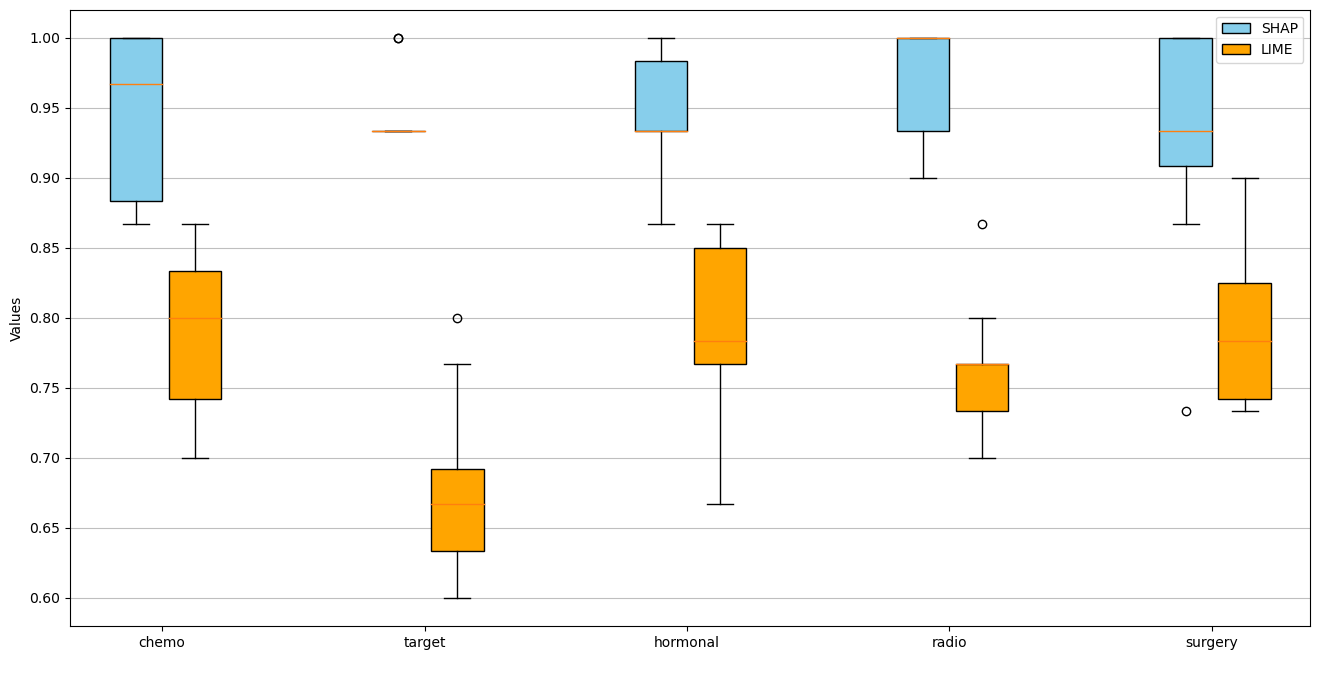

In [14]:

data, X, Y, classes_names = data_read_function( )
stability_Plot_Data={}
Treatments=['chemo','target','hormonal','radio','surgery']
for treatment_name in Treatments :
    Stability_Plot_Data= Lime_Shap_stability(data, X, Y, classes_names, stability_Plot_Data, treatment_name)
    
colors = ['skyblue', 'orange'] # Bar colors in plot
Plot_the_data(Stability_Plot_Data, colors)

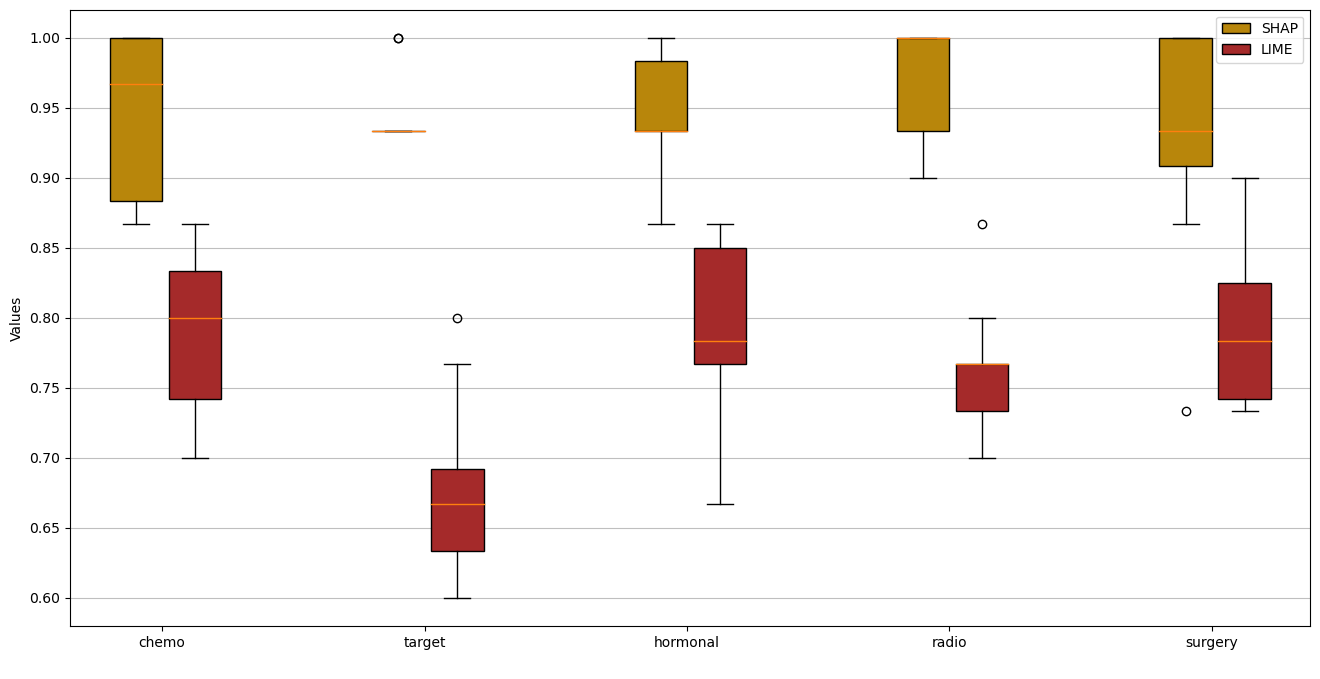

In [15]:
colors = ['darkgoldenrod', 'brown'] # Bar colors in plot
Plot_the_data(Stability_Plot_Data, colors)


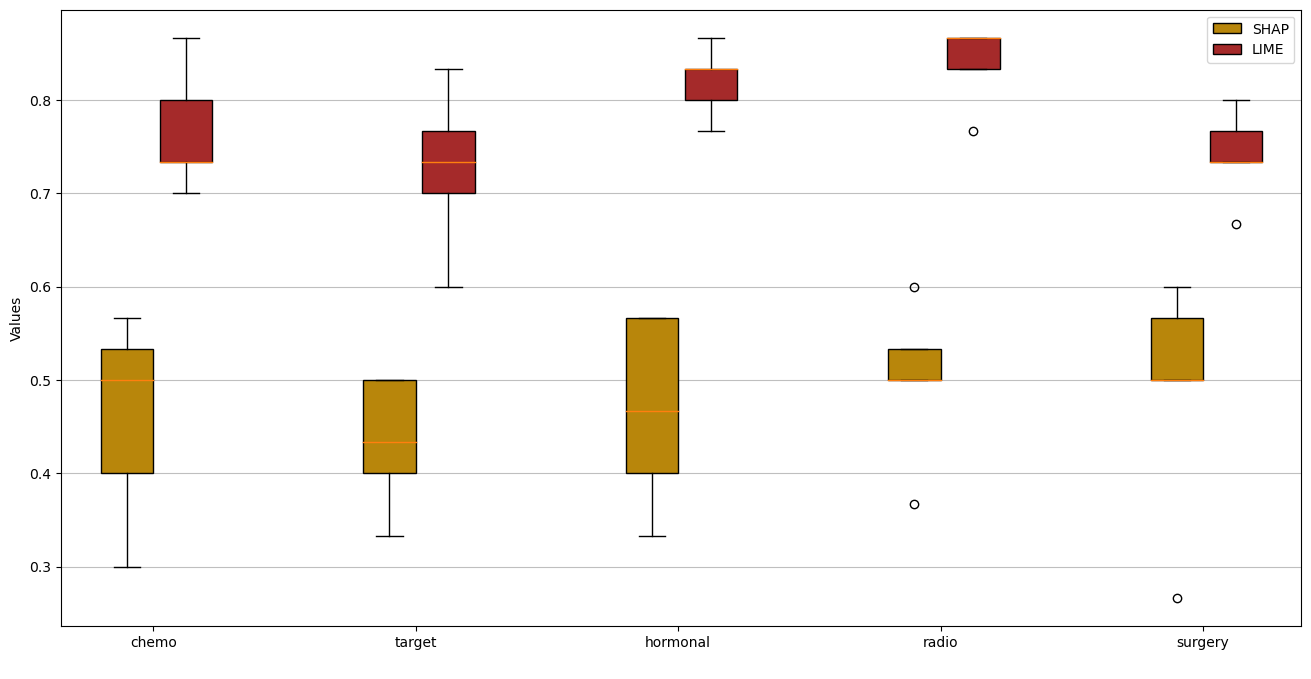

In [1019]:
colors = ['darkgoldenrod', 'brown'] # Bar colors in plot
Plot_the_data(Stability_Plot_Data, colors)


In [ ]:
medical_comparison_Plot_Data= {'chemo': [[0.5384615384615384,0.6153846153846154, 0.46153846153846156, 0.6923076923076923, 0.5, 0.5769230769230769, 0.5769230769230769, 0.5], [0.4230769230769231, 0.4230769230769231, 0.6153846153846154, 0.46153846153846156,  0.4230769230769231, 0.4230769230769231, 0.5384615384615384, 0.34615384615384615]],
 'target': [[0.6153846153846154, 0.5, 0.46153846153846156, 0.6538461538461539, 0.5, 0.5769230769230769, 0.5, 0.4230769230769231, 0.5384615384615384,0.5],
  [0.4230769230769231, 0.2692307692307692, 0.5384615384615384, 0.46153846153846156, 0.5769230769230769,  0.46153846153846156, 0.5769230769230769, 0.4230769230769231, 0.5, 0.46153846153846156]],
 'hormonal': [[0.4230769230769231, 0.5384615384615384,
   0.5769230769230769,
   0.6923076923076923,
   0.6153846153846154,
   0.5384615384615384,
   0.38461538461538464,
   0.6153846153846154,
   0.38461538461538464,
   0.38461538461538464],
  [0.4230769230769231,
   0.5,
   0.34615384615384615,
   0.4230769230769231,
   0.3076923076923077,
   0.4230769230769231,
   0.5384615384615384,
   0.46153846153846156,
   0.46153846153846156,
   0.5384615384615384]],
 'radio': [[0.38461538461538464,
   0.4230769230769231,
   0.4230769230769231,
   0.5,
   0.38461538461538464,
   0.5769230769230769,
   0.5,
   0.38461538461538464,
   0.46153846153846156,
   0.46153846153846156],
  [0.38461538461538464,
   0.46153846153846156,
   0.4230769230769231,
   0.2692307692307692,
   0.46153846153846156,
   0.4230769230769231,
   0.34615384615384615,
   0.38461538461538464,
   0.46153846153846156,
   0.3076923076923077]],
 'surgery': [[0.4230769230769231,
   0.5384615384615384,
   0.5,
   0.4230769230769231,
   0.5,
   0.6153846153846154,
   0.5384615384615384,
   0.46153846153846156,
   0.38461538461538464,
   0.6153846153846154],
  [0.34615384615384615,
   0.46153846153846156,
   0.46153846153846156,
   0.5384615384615384,
   0.2692307692307692,
   0.4230769230769231,
   0.5384615384615384,
   0.34615384615384615,
   0.46153846153846156,
   0.4230769230769231]]}

Fidelity_Plot_Data={'chemo': [[0.5454173609718891,
   0.5048407485014078,
   0.7437982084443666,
   0.5608691512263343,
   0.5642678616518061,
   0.5551432014560287,
   0.43991822366150163,
   0.502965085652823,
   0.6822241515204459,
   0.49239459903430083,
   0.800215185492993,
   0.595335984329791,
   0.5700606477744339,
   0.3638768924225574,
   0.7442717221430447],
  [0.21590347040027846,
   0.21818766247123778,
   0.23706353938763725,
   0.2629607757400846,
   0.2566807429213346,
   0.22274807991279244,
   0.2353111727315753,
   0.23513967039327344,
   0.23621581728307472,
   0.2424981897511207,
   0.21253970208696227,
   0.23656529980736818,
   0.2518201063996617,
   0.2374111159141451,
   0.20562500407990714]],
 'target': [[0.6114027767004311,
   0.39950938255668517,
   0.3714043950393887,
   0.5651638546875493,
   0.5171161853101808,
   0.408480321079239,
   0.729405358149694,
   0.6094754617658639,
   0.6284946169303048,
   0.6623258992936597,
   0.4259570987660566,
   0.43720328695686256,
   0.4926456240804156,
   0.3379163505964832,
   0.42863722554318523],
  [0.48527227648272786,
   0.46386438867087687,
   0.4726846263048736,
   0.4890597472529783,
   0.4896244839148648,
   0.48293909675199664,
   0.47323227918266575,
   0.4856007582926263,
   0.4690269746148711,
   0.48126396515092906,
   0.4798176479486037,
   0.48267134465412986,
   0.482485372298862,
   0.46731089975201046,
   0.47328522590321365]],
 'hormonal': [[0.3818073976477197,
   0.37169141345821,
   0.5608704802215857,
   0.60709920451118,
   0.40892493378848144,
   0.4434570810768966,
   0.39958957316035487,
   0.46573916138663357,
   0.6586057445542437,
   0.4683964842890952,
   0.42736344616421024,
   0.5399849435289039,
   0.5890397919083996,
   0.5754885799436834,
   0.6038544142407986],
  [0.3998035902353858,
   0.40074284811426497,
   0.3803911425953789,
   0.4063209934002827,
   0.4058654328249951,
   0.42746386295344707,
   0.398629215380117,
   0.4066843591008189,
   0.4232593426961042,
   0.3879259961132382,
   0.39998891270433856,
   0.3925135182992787,
   0.3706818479202241,
   0.3995688094418012,
   0.3506255537444457]],
 'radio': [[0.5778767293635835,
   0.674353965026519,
   0.5183679628630451,
   0.6697670213534037,
   0.5048975738649963,
   0.6160355714181389,
   0.43950632274369583,
   0.6953662513803204,
   0.598447208650063,
   0.743338680674297,
   0.53431815986319,
   0.4870415729308035,
   0.5663093693143467,
   0.5267255607506087,
   0.487042562998441],
  [0.3368207757992264,
   0.35697740813188095,
   0.3492968807623822,
   0.3367140348187414,
   0.34486502732412494,
   0.34322989594933573,
   0.36594508997755437,
   0.3007384203879452,
   0.3463243896174071,
   0.35449206060431004,
   0.3504312023712415,
   0.35136136217067304,
   0.3481600718552864,
   0.35412662202411194,
   0.3462631867768554]],
 'surgery': [[0.4943499950305783,
   0.596584942868085,
   0.673732885997425,
   0.6596730387189957,
   0.6767369241187499,
   0.5484928979769037,
   0.7631974103057886,
   0.6844144741521417,
   0.6460859003484898,
   0.26046641401441406,
   0.6010823103250525,
   0.6574796715893141,
   0.6018112834608097,
   0.7509198027454235,
   0.6496802782311264],
  [0.6276772663463304,
   0.6205371289757972,
   0.6241866080165105,
   0.5745121294202147,
   0.5856808582748871,
   0.5672285875974521,
   0.5688418384729919,
   0.6094492251823674,
   0.5588038323085431,
   0.5791248700533786,
   0.5816296952451137,
   0.5891010227066992,
   0.6170950656575014,
   0.6343774595398832,
   0.5738079351091903]]}
Stability_Plot_Data={'chemo': [[0.2333333333333333,
   0.3666666666666667,
   0.13333333333333333,
   0.5,
   0.3333333333333333,
   0.4666666666666666,
   0.3333333333333333,
   0.4000000000000001,
   0.5666666666666667,
   0.3666666666666667],
  [0.7666666666666666,
   0.8000000000000002,
   0.8333333333333334,
   0.8000000000000002,
   0.7666666666666666,
   0.7666666666666666,
   0.7333333333333334,
   0.8333333333333334,
   0.8333333333333334,
   0.8666666666666667]],
 'target': [[0.3666666666666667,
   0.5333333333333333,
   0.5666666666666668,
   0.4666666666666666,
   0.43333333333333335,
   0.26666666666666666,
   0.39999999999999997,
   0.5333333333333333,
   0.3333333333333333,
   0.4000000000000001],
  [0.8000000000000002,
   0.6666666666666666,
   0.7800000000000002,
   0.7000000000000001,
   0.7333333333333334,
   0.6666666666666666,
   0.7000000000000001,
   0.7333333333333334,
   0.7333333333333334,
   0.7000000000000001]],
 'hormonal': [[0.3333333333333333,
   0.5,
   0.5,
   0.4666666666666666,
   0.3666666666666667,
   0.5666666666666667,
   0.5,
   0.3666666666666667,
   0.5333333333333333,
   0.5],
  [0.7333333333333334,
   0.7666666666666666,
   0.7333333333333334,
   0.7333333333333334,
   0.8000000000000002,
   0.7666666666666666,
   0.8333333333333334,
   0.6666666666666666,
   0.9,
   0.8000000000000002]],
 'radio': [[0.3,
   0.5333333333333333,
   0.5666666666666667,
   0.5666666666666667,
   0.4666666666666666,
   0.6999999999999998,
   0.5666666666666667,
   0.3333333333333333,
   0.43333333333333335,
   0.26666666666666666],
  [0.8333333333333334,
   0.6999999999999998,
   0.8000000000000002,
   0.8666666666666667,
   0.8333333333333334,
   0.6999999999999998,
   0.7333333333333334,
   0.7666666666666666,
   0.7333333333333334,
   0.8333333333333334]],
 'surgery': [[0.8000000000000002,
  0.4000000000000001,
  0.6666666666666666,
  0.4666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  0.8666666666666667,
  0.6666666666666666,
  0.7333333333333334,
  0.7333333333333334],
  [0.7333333333333334,
   0.8000000000000002,
   0.8333333333333334,
   0.6333333333333333,
   0.7666666666666666,
   0.7666666666666666,
   0.7000000000000001,
   0.7666666666666666,
   0.7666666666666666,
   0.6333333333333333]]}
